# $\color{black}{\text{Kapittel 1 - Følger og rekker}}$

# $\color{red}{\text{Kapittel 2 - Integralregning}}$

In [ ]:
# -*- coding: utf-8 -*-
import sympy as sp
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output, Math, Markdown

# --- SYMBOLSK OPPSETT ---
# Definer symboler. 'oo' er SymPys uendelighet.
x, y = sp.symbols('x y')
oo = sp.oo

# --- HJELPEFUNKSJONER ---

def parse_expression(expr_str):
    """Trygt parser en streng til et SymPy-uttrykk."""
    try:
        # Erstatt standard potensoperator med Pythons versjon
        safe_expr_str = expr_str.replace('^', '**')
        # Sympify konverterer strengen til et matematisk uttrykk
        return sp.sympify(safe_expr_str)
    except (sp.SympifyError, SyntaxError) as e:
        raise ValueError(f"Ugyldig funksjonsuttrykk: '{expr_str}'. Feil: {e}")

def create_numpy_function(expr):
    """Konverterer et SymPy-uttrykk til en rask NumPy-funksjon for plotting."""
    # lambdify er den anbefalte måten å gjøre dette på. Mye tryggere enn eval().
    return sp.lambdify(x, expr, modules=['numpy'])

# --- KJERNEFUNKSJONER (LOGIKK FOR HVER OPERASJON) ---

def handle_derivation(f_expr):
    derivative = sp.diff(f_expr, x)
    display(Math(f"f'(x) = \\frac{{d}}{{dx}} \\left( {sp.latex(f_expr)} \\right) = {sp.latex(derivative)}"))

def handle_indefinite_integral(f_expr):
    antiderivative = sp.integrate(f_expr, x)
    # Legg til "+ C" for å være fullstendig
    display(Math(f"\\int \\left( {sp.latex(f_expr)} \\right) \\,dx = {sp.latex(antiderivative)} + C"))

def handle_definite_integral(f_expr, a, b):
    antiderivative = sp.integrate(f_expr, x)
    display(Math(f"\\text{{1. Finn den antideriverte: }} F(x) = \\int \\left( {sp.latex(f_expr)} \\right) \\,dx = {sp.latex(antiderivative)}"))
    
    result = sp.integrate(f_expr, (x, a, b))
    # Vis utregningen med innsatte grenser
    eval_b = antiderivative.subs(x, b)
    eval_a = antiderivative.subs(x, a)
    display(Math(f"\\text{{2. Evaluer grensene: }} F(b) - F(a) = \\left( {sp.latex(eval_b)} \\right) - \\left( {sp.latex(eval_a)} \\right)"))

    # Vis det endelige svaret, både eksakt og som desimaltall
    display(Math(f"\\text{{Resultat: }} \\int_{{{a}}}^{{{b}}} \\left( {sp.latex(f_expr)} \\right) \\,dx = {sp.latex(result)} \\approx {result.evalf(6)}"))
    plot_functions('Bestemt integral', f_expr=f_expr, a=float(a), b=float(b))

def handle_area_between_graphs(f_expr, g_expr, a, b, find_intersections):
    if find_intersections:
        try:
            # Løs f(x) = g(x) for x, kun reelle løsninger
            intersections = sp.solve(f_expr - g_expr, x, domain=sp.S.Reals)
            intersections.sort()
            if len(intersections) >= 2:
                a, b = intersections[0], intersections[-1]
                a_input.value = float(a)
                b_input.value = float(b)
                display(Markdown(f"**Skjæringspunkter funnet og brukt som grenser:** `a = {a}` og `b = {b}`"))
            else:
                display(Markdown("**Fant færre enn 2 reelle skjæringspunkter. Bruker manuelle grenser.**"))
        except NotImplementedError:
             display(Markdown("**Kunne ikke løse for skjæringspunkter analytisk. Bruk manuelle grenser.**"))

    # Integrer absoluttverdien av differansen for å sikre positivt areal
    integrand = sp.Abs(f_expr - g_expr)
    area = sp.integrate(integrand, (x, a, b))
    
    display(Math(f"\\text{{Areal }} A = \\int_{{{a}}}^{{{b}}} |f(x) - g(x)| \\,dx = \\int_{{{a}}}^{{{b}}} \\left| {sp.latex(f_expr)} - \\left( {sp.latex(g_expr)} \\right) \\right| \\,dx"))
    display(Math(f"A = {sp.latex(area)} \\approx {area.evalf(6)}"))
    plot_functions('Areal mellom grafer', f_expr=f_expr, g_expr=g_expr, a=float(a), b=float(b))

def handle_volume_revolution(f_expr, g_expr, a, b, axis='x'):
    if axis == 'x':
        # Volum ved rotasjon om x-aksen (skive-/vaskemetoden)
        integrand = sp.pi * (f_expr**2 - g_expr**2)
        display(Markdown("### Volum av omdreiningslegeme om x-aksen (Skivemetoden)"))
        display(Math(f"V = \\pi \\int_{{{a}}}^{{{b}}} \\left( (f(x))^2 - (g(x))^2 \\right) \\,dx"))
        display(Math(f"V = \\pi \\int_{{{a}}}^{{{b}}} \\left( \\left({sp.latex(f_expr)}\\right)^2 - \\left({sp.latex(g_expr)}\\right)^2 \\right) \\,dx"))
    else: # axis == 'y'
        # Volum ved rotasjon om y-aksen (sylinderskallmetoden)
        integrand = 2 * sp.pi * x * (f_expr - g_expr)
        display(Markdown("### Volum av omdreiningslegeme om y-aksen (Sylinderskallmetoden)"))
        display(Math(f"V = 2\\pi \\int_{{{a}}}^{{{b}}} x \\left( f(x) - g(x) \\right) \\,dx"))
        display(Math(f"V = 2\\pi \\int_{{{a}}}^{{{b}}} x \\left( \\left({sp.latex(f_expr)}\\right) - \\left({sp.latex(g_expr)}\\right) \\right) \\,dx"))

    volume = sp.integrate(integrand, (x, a, b))
    display(Math(f"V = {sp.latex(volume)} \\approx {volume.evalf(6)}"))
    plot_functions('Volum', f_expr=f_expr, g_expr=g_expr, a=float(a), b=float(b), title_extra=f"om {axis}-aksen")

def handle_numerical_integration(f_str, a, b):
    # Bruk SciPy.quad for rask og nøyaktig numerisk integrasjon
    f_numpy = lambda x_val: eval(f_str, {"x": x_val, "np": np})
    result, error = integrate.quad(f_numpy, a, b)
    display(Markdown(f"**Resultat:** `{result}`"))
    display(Markdown(f"**Estimert feilmargin:** `{error}`"))
    
    # For plotting må vi parse uttrykket til SymPy først
    f_expr = parse_expression(f_str)
    plot_functions('Numerisk integral', f_expr=f_expr, a=a, b=b)

# --- PLOTTEFUNKSJON ---

def plot_functions(op_name, f_expr, g_expr=None, a=0, b=1, title_extra=""):
    # Lag numeriske funksjoner for plotting
    f_numpy = create_numpy_function(f_expr)
    
    # Lag et tett rutenett av x-verdier for en jevn graf
    x_vals = np.linspace(a, b, 500)
    y_vals_f = f_numpy(x_vals)

    plt.figure(figsize=(10, 6))
    plt.plot(x_vals, y_vals_f, label=f'f(x) = {f_expr}', color='blue')
    
    plot_title = f"Visualisering av {op_name} {title_extra}"
    
    if g_expr is not None:
        g_numpy = create_numpy_function(g_expr)
        y_vals_g = g_numpy(x_vals)
        plt.plot(x_vals, y_vals_g, label=f'g(x) = {g_expr}', color='green')
        
        # Fyll området mellom grafene
        plt.fill_between(x_vals, y_vals_f, y_vals_g, where=(y_vals_f > y_vals_g), 
                         interpolate=True, color='purple', alpha=0.3, label='Areal (f > g)')
        plt.fill_between(x_vals, y_vals_f, y_vals_g, where=(y_vals_g >= y_vals_f), 
                         interpolate=True, color='orange', alpha=0.3, label='Areal (g >= f)')

        # Finn og plott skjæringspunkter i intervallet
        try:
            intersections = sp.solve(f_expr - g_expr, x, domain=sp.S.Reals)
            real_intersections_in_range = [i for i in intersections if a <= i <= b]
            if real_intersections_in_range:
                y_intersections = f_numpy(np.array(real_intersections_in_range, dtype=float))
                plt.scatter(real_intersections_in_range, y_intersections, color='red', zorder=5, label='Skjæringspunkter')
        except NotImplementedError:
            pass # Ignorer om SymPy ikke kan løse ligningen

    elif op_name in ['Bestemt integral', 'Numerisk integral']:
        plt.fill_between(x_vals, y_vals_f, alpha=0.3, color='orange', label='Integrasjonsområde')

    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.title(plot_title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.ylim(min(y_vals_f.min(), 0) - 1, y_vals_f.max() + 1) # Juster y-aksen
    plt.xlim(a - 0.1*(b-a), b + 0.1*(b-a)) # Litt pusterom på x-aksen
    plt.show()

# --- OPPSETT AV WIDGETS (BRUKERGRENSESNITT) ---

# Beskrivelse av verktøyet
display(Markdown("# R2 Kalkulus-verktøy"))
display(Markdown("Dette verktøyet utfører symbolske og numeriske beregninger for derivasjon og integrasjon. "
                 "Bruk standard Python-syntaks for funksjoner, f.eks. `x**2` for $x^2$, `sp.sin(x)` for $\\sin(x)$, `sp.exp(x)` for $e^x$. "
                 "For uendelig, skriv `oo` (to små o-er)."))

# Hovedmeny
operation = widgets.Dropdown(
    options=[
        'Derivasjon',
        'Ubestemt integral',
        'Bestemt integral',
        'Areal mellom grafer',
        'Volum om x-aksen',
        'Volum om y-aksen',
        'Numerisk integral'
    ],
    description='Velg operasjon:',
    style={'description_width': 'initial'}
)

# Inndatafelt
function_input = widgets.Text(value='sin(x)', description='f(x):', layout={'width': '400px'})
function_g_input = widgets.Text(value='cos(x)', description='g(x):', layout={'width': '400px'})
a_input = widgets.Text(value='0', description='a (nedre grense):')
b_input = widgets.Text(value='pi/2', description='b (øvre grense):')
find_intersections_checkbox = widgets.Checkbox(value=False, description='Finn grenser automatisk')
run_button = widgets.Button(description="Kjør beregning", button_style='success')

# Område for output
output_area = widgets.Output()

# Ordne widgets i bokser for bedre layout
input_widgets = widgets.VBox([
    operation,
    function_input,
    function_g_input,
    widgets.HBox([a_input, b_input]),
    find_intersections_checkbox
])

# --- LOGIKK FOR BRUKERGRENSESNITT ---

def update_ui(*args):
    """Viser/skjuler widgets basert på valgt operasjon."""
    op = operation.value
    function_g_input.layout.display = 'none'
    a_input.layout.display = 'none'
    b_input.layout.display = 'none'
    find_intersections_checkbox.layout.display = 'none'

    if op == 'Areal mellom grafer':
        function_g_input.layout.display = 'flex'
        a_input.layout.display = 'flex'
        b_input.layout.display = 'flex'
        find_intersections_checkbox.layout.display = 'flex'
    elif op in ['Bestemt integral', 'Numerisk integral']:
        a_input.layout.display = 'flex'
        b_input.layout.display = 'flex'
    elif op in ['Volum om x-aksen', 'Volum om y-aksen']:
        function_g_input.description = "g(x) (nedre kurve):"
        function_g_input.value = "0" # Standard er rotasjon av areal under én graf
        function_g_input.layout.display = 'flex'
        a_input.layout.display = 'flex'
        b_input.layout.display = 'flex'

operation.observe(update_ui, names='value')

def run_calculation_on_click(b):
    """Hovedfunksjon som kalles når knappen trykkes."""
    with output_area:
        clear_output(wait=True)
        try:
            op = operation.value
            f_str = function_input.value
            f_expr = parse_expression(f_str)

            # Hent grenser kun om de trengs
            if op not in ['Derivasjon', 'Ubestemt integral']:
                a = parse_expression(a_input.value)
                b = parse_expression(b_input.value)
            
            # Hent g(x) kun om det trengs
            if op in ['Areal mellom grafer', 'Volum om x-aksen', 'Volum om y-aksen']:
                g_expr = parse_expression(function_g_input.value)

            # Kall riktig logikkfunksjon basert på valg
            if op == 'Derivasjon':
                handle_derivation(f_expr)
            elif op == 'Ubestemt integral':
                handle_indefinite_integral(f_expr)
            elif op == 'Bestemt integral':
                handle_definite_integral(f_expr, a, b)
            elif op == 'Areal mellom grafer':
                handle_area_between_graphs(f_expr, g_expr, a, b, find_intersections_checkbox.value)
            elif op == 'Volum om x-aksen':
                handle_volume_revolution(f_expr, g_expr, a, b, axis='x')
            elif op == 'Volum om y-aksen':
                handle_volume_revolution(f_expr, g_expr, a, b, axis='y')
            elif op == 'Numerisk integral':
                # Numerisk trenger den originale strengen
                handle_numerical_integration(f_str, float(a), float(b))

        except Exception as e:
            # Vis feilmelding på en pen måte
            print(f"En feil oppstod: {e}")

run_button.on_click(run_calculation_on_click)

# Vis grensesnittet
display(input_widgets)
display(run_button)
display(output_area)

# Initialiser UI-visningen
update_ui()

# $\color{green}{\text{Kapittel 3 - Integrasjonsmetoder}}$

--- Eksempel: Bestemt Integral ---

📘 Teori:
∫[a,b] f(x) dx = F(b) - F(a)

Beregner bestemt integral av f(x) = 4 - x**2 fra -2 til 1...

Resultat:
1             
⌠             
⎮  ⎛     2⎞   
⎮  ⎝4 - x ⎠ dx
⌡             
-2             = 9 ≈ 9.0000



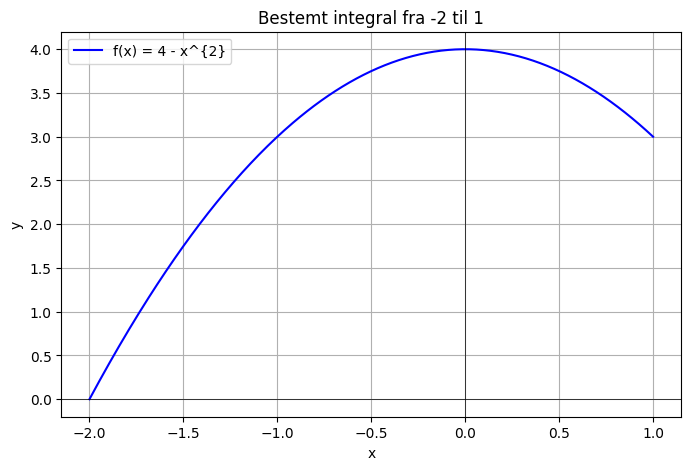



--- Eksempel: Areal Mellom Grafer ---

📘 Teori:
A = ∫[a,b] |f(x) - g(x)| dx

Beregner areal mellom f(x) = 4 - x**2 og g(x) = x + 2 fra -2 til 1...
ℹ️ Fant ikke symbolsk løsning, bytter til numerisk integrasjon.

Resultat:
A = 1                 
⌠                 
⎮  │ 2        │   
⎮  │x  + x - 2│ dx
⌡                 
-2                 ≈ 4.5000



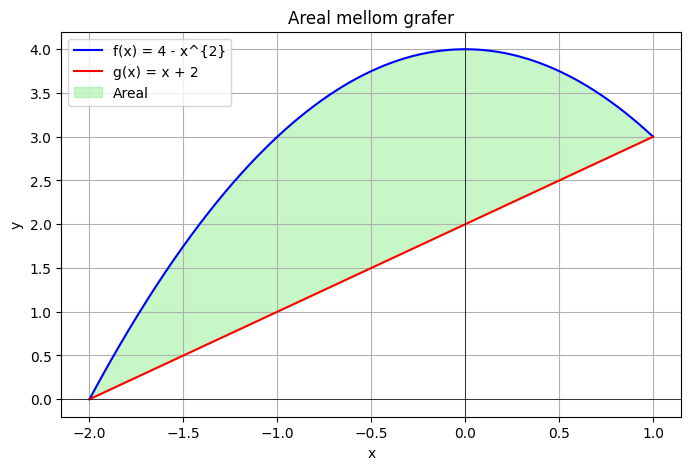



--- Eksempel: Ubestemt Integral ---

📘 Teori:
∫f(x) dx = F(x) + C

Beregner ubestemt integral...

Resultat:
⌠                
⎮ (x + cos(x)) dx
⌡                 =  2         
x          
── + sin(x)
2           + C



--- Eksempel: Volum (Rotasjon om x-akse) ---

📘 Teori:
V = π * ∫[a,b] [f(x)]^2 dx

Beregner volum (f(x) rotert om x-aksen) fra 0 til 4...

Resultat:
V = 4       
⌠       
⎮ π⋅x dx
⌡       
0        = 8⋅π ≈ 25.1327



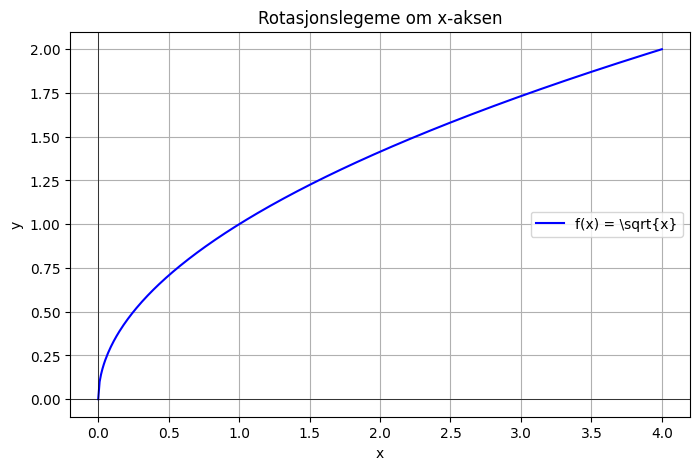



--- Eksempel: Differensiallikning ---

📘 Teori:
Løser y' = f(x,y) for å finne y(x).

Løser differensiallikning y' = -0.5*y med y(0) = 4...

Resultat:
          -0.5⋅x
y(x) = 4⋅ℯ      


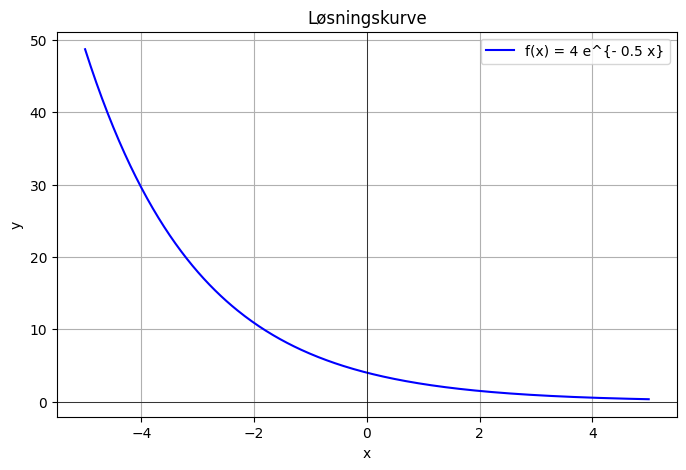

In [7]:
# --- IMPORTER BIBLIOTEKER ---
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, IntegrationWarning
import warnings

# --- SYMPY OPPSETT ---
x, y = sp.symbols('x y')
sp.init_printing(use_latex='mathjax') # Best for miljøer som kan vise LaTeX

# --- HJELPEFUNKSJONER ---

def parse_expr(expr_str, symbol=x):
    """
    Konverterer en tekststreng til et SymPy-uttrykk.
    VIKTIG: Bruk Python-syntaks, f.eks. ** for eksponenter (x**2).
    """
    try:
        local_dict = {
            'x': x, 'y': y, 'pi': sp.pi, 'e': sp.E,
            'sin': sp.sin, 'cos': sp.cos, 'tan': sp.tan,
            'asin': sp.asin, 'acos': sp.acos, 'atan': sp.atan,
            'sqrt': sp.sqrt, 'ln': sp.log, 'log': sp.log,
            'exp': sp.exp
        }
        return sp.parse_expr(expr_str, local_dict=local_dict)
    except Exception as e:
        print(f"🚨 Feil i uttrykket '{expr_str}': {e}")
        return None

def beregn_integral(integrand, var, a, b):
    """
    Beregner et bestemt integral. Prøver symbolsk, faller tilbake på numerisk.
    """
    try:
        antideriv = sp.integrate(integrand, var)
        if isinstance(antideriv, sp.Integral):
            raise ValueError("Fant ikke symbolsk antiderivert.")
        symbolsk_resultat = antideriv.subs(var, b) - antideriv.subs(var, a)
        return symbolsk_resultat, symbolsk_resultat.evalf(), False
    except (ValueError, TypeError, NotImplementedError):
        print("ℹ️ Fant ikke symbolsk løsning, bytter til numerisk integrasjon.")
        f_numpy = sp.lambdify(var, integrand, ['numpy', 'scipy'])
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=IntegrationWarning)
                numerisk_verdi, error_est = quad(f_numpy, float(a), float(b))
                if error_est > 1e-3:
                    print(f"⚠️ ADVARSEL: Høyt feilestimat ({error_est:.2e}). Resultatet kan være unøyaktig.")
                return None, numerisk_verdi, True
        except Exception as e:
            print(f"🚨 Numerisk integrasjon feilet: {e}")
            return None, None, True

# --- VISUALISERING- OG TEORIFUNKSJONER ---

def vis_teori(metode):
    """Viser en kort teoretisk forklaring for valgt metode."""
    teori = {
        'Ubestemt integral': "∫f(x) dx = F(x) + C",
        'Bestemt integral': "∫[a,b] f(x) dx = F(b) - F(a)",
        'Areal mellom grafer': "A = ∫[a,b] |f(x) - g(x)| dx",
        'Volum (rotasjon om x-akse)': "V = π * ∫[a,b] [f(x)]^2 dx",
        'Overflate (rotasjon om x-akse)': "O = 2π * ∫[a,b] f(x) * sqrt(1 + [f'(x)]^2) dx",
        'Differensiallikninger': "Løser y' = f(x,y) for å finne y(x).",
    }
    print("\n📘 Teori:")
    print(teori.get(metode, "Ingen teori tilgjengelig for denne metoden."))

def vis_graf_2d(f_expr, a, b, f2_expr=None, mellom=False, plot_title="Funksjonsgraf"):
    """Tegner 2D-grafen av funksjonen(e)."""
    t = np.linspace(float(a), float(b), 400)
    try:
        f_np = sp.lambdify(x, f_expr, 'numpy')
        y_vals = f_np(t)
    except Exception as e:
        print(f"🚨 Kunne ikke tegne graf for f(x): {e}")
        return

    plt.figure(figsize=(8, 5))
    plt.plot(t, y_vals, label=f'f(x) = {sp.latex(f_expr)}', color='blue')

    if f2_expr:
        try:
            f2_np = sp.lambdify(x, f2_expr, 'numpy')
            y2_vals = f2_np(t)
            plt.plot(t, y2_vals, label=f'g(x) = {sp.latex(f2_expr)}', color='red')
            if mellom:
                plt.fill_between(t, y_vals, y2_vals, color='lightgreen', alpha=0.5, interpolate=True, label='Areal')
        except Exception as e:
            print(f"🚨 Kunne ikke tegne graf for g(x): {e}")

    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(plot_title)
    plt.legend()
    plt.grid(True)
    plt.show()

# --- MATEMATISKE FUNKSJONER ---

def ubestemt_integral(f_str):
    vis_teori('Ubestemt integral')
    f = parse_expr(f_str)
    if f is None: return
    print("\nBeregner ubestemt integral...")
    integrert = sp.integrate(f, x)
    print("\nResultat:")
    print(sp.pretty(sp.Integral(f, x)), "=", sp.pretty(integrert), "+ C\n")

def bestemt_integral(f_str, a, b):
    vis_teori('Bestemt integral')
    f = parse_expr(f_str)
    if f is None: return
    print(f"\nBeregner bestemt integral av f(x) = {f_str} fra {a} til {b}...")
    integral_expr = sp.Integral(f, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(f, x, a, b)

    print("\nResultat:")
    if numerisk_res is None:
        print(f"{sp.pretty(integral_expr)} kunne ikke beregnes.")
        return

    if symbolsk_res is not None:
        print(sp.pretty(integral_expr), "=", sp.pretty(symbolsk_res), f"≈ {numerisk_res:.4f}\n")
    else:
        print(sp.pretty(integral_expr), f"≈ {numerisk_res:.4f}\n")
    vis_graf_2d(f, a, b, plot_title=f"Bestemt integral fra {a} til {b}")

def areal_mellom(f1_str, f2_str, a, b):
    vis_teori('Areal mellom grafer')
    f1 = parse_expr(f1_str)
    f2 = parse_expr(f2_str)
    if f1 is None or f2 is None: return
    print(f"\nBeregner areal mellom f(x) = {f1_str} og g(x) = {f2_str} fra {a} til {b}...")
    integrand = sp.Abs(f1 - f2)
    integral_expr = sp.Integral(integrand, (x, a, b))
    _, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        print("\nResultat:")
        print("A =", sp.pretty(integral_expr), f"≈ {numerisk_res:.4f}\n")
    vis_graf_2d(f1, a, b, f2_expr=f2, mellom=True, plot_title="Areal mellom grafer")

def volum_x_akse(f_str, a, b):
    vis_teori('Volum (rotasjon om x-akse)')
    f = parse_expr(f_str)
    if f is None: return
    print(f"\nBeregner volum (f(x) rotert om x-aksen) fra {a} til {b}...")
    integrand = sp.pi * f**2
    integral_expr = sp.Integral(integrand, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        print("\nResultat:")
        if symbolsk_res is not None:
            print("V =", sp.pretty(integral_expr), "=", sp.pretty(symbolsk_res), f"≈ {numerisk_res:.4f}\n")
        else:
            print("V =", sp.pretty(integral_expr), f"≈ {numerisk_res:.4f}\n")
    vis_graf_2d(f, a, b, plot_title="Rotasjonslegeme om x-aksen")

def los_diff_ligning(hoyreside_str, x0_val, y0_val):
    vis_teori('Differensiallikninger')
    hoyreside = parse_expr(hoyreside_str, symbol=y)
    if hoyreside is None: return
    print(f"\nLøser differensiallikning y' = {hoyreside_str} med y({x0_val}) = {y0_val}...")
    y_func = sp.Function('y')(x)
    eq = sp.Eq(y_func.diff(x), hoyreside.subs(y, y_func))
    ics = {y_func.subs(x, x0_val): y0_val}

    try:
        losning = sp.dsolve(eq, y_func, ics=ics)
        print("\nResultat:")
        print(sp.pretty(losning))
        
        # Prøv å plotte løsningen
        if losning.rhs.free_symbols == {x}:
            vis_graf_2d(losning.rhs, float(x0_val) - 5, float(x0_val) + 5, plot_title="Løsningskurve")
    except Exception as e:
        print(f"🚨 Kunne ikke løse differensiallikningen: {e}")

# --- HOVEDPROGRAM ---
# Siden vi ikke kan bruke et interaktivt grensesnitt,
# kaller vi funksjonene direkte her.
# Endre verdiene under for å kjøre dine egne beregninger.
if __name__ == '__main__':
    print("--- Eksempel: Bestemt Integral ---")
    bestemt_integral("4 - x**2", a=-2, b=1)

    print("\n\n--- Eksempel: Areal Mellom Grafer ---")
    areal_mellom("4 - x**2", "x + 2", a=-2, b=1)

    print("\n\n--- Eksempel: Ubestemt Integral ---")
    ubestemt_integral("cos(x) + x")

    print("\n\n--- Eksempel: Volum (Rotasjon om x-akse) ---")
    volum_x_akse("sqrt(x)", a=0, b=4)
    
    print("\n\n--- Eksempel: Differensiallikning ---")
    los_diff_ligning("-0.5*y", x0_val=0, y0_val=4)

In [9]:
# --- IMPORTER BIBLIOTEKER ---
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, IntegrationWarning
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display, Math, clear_output
import warnings
# Importer for avansert parsing av brukerinput
from sympy.parsing.sympy_parser import parse_expr as sympy_parse_expr, standard_transformations, implicit_multiplication_application

# --- SYMPY OPPSETT ---
# Definerer de matematiske symbolene vi vil jobbe med
x, y = sp.symbols('x y')
# Sørger for pen, matematisk utskrift (LaTeX-stil)
sp.init_printing(use_latex='mathjax')


# --- HJELPEFUNKSJONER ---

def parse_expr(expr_str: str):
    """
    Konverterer en tekststreng til et SymPy-uttrykk med forbedret robusthet.
    - Erstatter ^ med ** for potensregning.
    - Tillater implisitt multiplikasjon (f.eks. '2x', 'sin(x)x').
    - Kjenner igjen vanlige matematiske funksjoner og konstanter (også norske, som 'rot').
    """
    try:
        # Standard Python-notasjon for potenser
        expr_str_py = expr_str.replace('^', '**')

        # Ordliste for å oversette vanlige/norske funksjonsnavn til SymPy
        local_dict = {
            'x': x, 'y': y,
            'pi': sp.pi, 'e': sp.E,
            'sin': sp.sin, 'cos': sp.cos, 'tan': sp.tan,
            'asin': sp.asin, 'acos': sp.acos, 'atan': sp.atan, 'atan2': sp.atan2,
            'sinh': sp.sinh, 'cosh': sp.cosh, 'tanh': sp.tanh,
            'sqrt': sp.sqrt, 'rot': sp.sqrt, # 'rot' er norsk for 'root'
            'ln': sp.log, 'log': sp.log,
            'exp': sp.exp,
            'abs': sp.Abs,
            'factorial': sp.factorial
        }

        # Transformeringsregler for å tolke f.eks. '2x' som '2*x'
        transformations = standard_transformations + (implicit_multiplication_application,)

        # Bruker SymPys avanserte parser. global_dict=None for økt sikkerhet.
        return sympy_parse_expr(expr_str_py, local_dict=local_dict, transformations=transformations, global_dict=None)

    except Exception as e:
        print(f"🚨 Kunne ikke tolke uttrykket '{expr_str}'. Feil: {e}")
        print("   Tips: Bruk '*' for multiplikasjon (f.eks. '2*x') og sjekk at parenteser er balansert.")
        return None

def beregn_integral(integrand, var, a, b):
    """
    Beregner et bestemt integral. Prøver symbolsk først, deretter numerisk.
    Returnerer symbolsk resultat, numerisk verdi og om den ble løst numerisk.
    """
    try:
        # Prøv å integrere symbolsk for en eksakt løsning
        antideriv = sp.integrate(integrand, var)

        # Sjekk om SymPy klarte å finne den antideriverte
        if isinstance(antideriv, sp.Integral):
            raise ValueError("Fant ikke symbolsk antiderivert.")

        # Evaluer grensene symbolsk for å få et eksakt uttrykk
        symbolsk_resultat = antideriv.subs(var, b) - antideriv.subs(var, a)

        # Prøv å evaluere til et flyttall. Kan feile for komplekse uttrykk.
        numerisk_verdi = symbolsk_resultat.evalf()
        return symbolsk_resultat, float(numerisk_verdi), False

    except (ValueError, TypeError, NotImplementedError, AttributeError):
        # Hvis symbolsk løsning feiler, bytt til numerisk integrasjon (Scipy Quad)
        print("ℹ️ Fant ikke eksakt symbolsk løsning, bytter til numerisk integrasjon.")
        f_numpy = sp.lambdify(var, integrand, ['numpy', 'scipy'])
        try:
            # Ignorer advarsler fra Scipy som kan oppstå ved komplekse integraler
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=IntegrationWarning)
                numerisk_verdi, error_est = quad(f_numpy, float(a), float(b), limit=200)
                # Gi en advarsel hvis det numeriske resultatet er usikkert
                if error_est > 1e-3:
                    print(f"⚠️ ADVARSEL: Høyt feilestimat ({error_est:.2e}). Resultatet kan være unøyaktig.")
                return None, numerisk_verdi, True
        except Exception as e:
            print(f"🚨 Numerisk integrasjon feilet: {e}")
            return None, None, True

# --- VISUALISERING- OG TEORIFUNKSJONER ---

def vis_teori(metode):
    """Viser en kort teoretisk forklaring for valgt metode."""
    teori = {
        'Ubestemt integral': r"Den antideriverte: $$\int f(x) \,dx = F(x) + C$$",
        'Bestemt integral': r"Analyse av fundamentalteorem: $$\int_a^b f(x) \,dx = [F(x)]_a^b = F(b) - F(a)$$",
        'Areal mellom grafer': r"Areal som et integral: $$A = \int_a^b |f(x) - g(x)| \,dx$$",
        'Volum (rotasjon om x-akse)': r"Skivemetoden: $$V = \pi \int_a^b [f(x)]^2 \,dx$$",
        'Overflate (rotasjon om x-akse)': r"Overflate av omdreiningslegeme: $$O = 2\pi \int_a^b |f(x)| \sqrt{1 + [f'(x)]^2} \,dx$$",
        'Volum (rotasjon om y-akse)': r"Skallmetoden: $$V = 2\pi \int_a^b |x \cdot f(x)| \,dx$$",
        'Uegentlig integral': r"Integral over et uendelig intervall: $$\int_a^\infty f(x) \,dx = \lim_{t \to \infty} \int_a^t f(x) \,dx$$",
        'Delbrøkoppspalting': r"Metode for å integrere rasjonale funksjoner ved å splitte dem i enklere brøker.",
        'Differensiallikninger': r"Løser $y' = f(x,y)$ med startvilkår $y(x_0)=y_0$ for å finne en partikulær løsning.",
    }
    print("\n📘 Teoretisk grunnlag:")
    display(Math(teori.get(metode, "Ingen teori tilgjengelig for denne metoden.")))

def vis_graf_2d(f_expr, a, b, f2_expr=None, fyll_mellom=False, plot_tittel="Funksjonsgraf"):
    """Tegner en 2D-graf av funksjonen(e) og håndterer brudd/asymptoter intelligent."""
    try:
        a_f, b_f = float(a), float(b)
        if a_f >= b_f:
            print("ℹ️ Kan ikke plotte grafen fordi startgrensen 'a' må være mindre enn sluttgrensen 'b'.")
            return
    except (ValueError, TypeError):
        print("🚨 Ugyldige grenser for plotting. Sørg for at 'a' og 'b' er tall.")
        return

    t = np.linspace(a_f, b_f, 800)
    plt.figure(figsize=(8, 5))

    try:
        # Konverter SymPy-uttrykk til en rask NumPy-funksjon for plotting
        f_np = sp.lambdify(x, f_expr, 'numpy')
        y_vals = f_np(t)

        # Smart plotting: Finn store sprang (asymptoter) og sett dem til NaN for å unngå vertikale linjer
        dy = np.diff(y_vals)
        median_dy = np.nanmedian(np.abs(dy))
        if median_dy is not None and median_dy > 1e-6:
            sprang_terskel = 20 * median_dy # Terskel for hva som er et "hopp"
            hopp_indekser = np.where(np.abs(dy) > sprang_terskel)[0]
            y_vals[hopp_indekser] = np.nan

        plt.plot(t, y_vals, label=f'$f(x) = {sp.latex(f_expr)}$', color='blue')

        # Automatisk justering av y-aksen for å unngå at asymptoter ødelegger plottet
        q1, q3 = np.nanquantile(y_vals, [0.1, 0.9])
        iqr = (q3 - q1) if (q3 is not None and q1 is not None and q3 > q1) else 1.0
        plt.ylim(max(np.nanmin(y_vals), q1 - 1.5 * iqr), min(np.nanmax(y_vals), q3 + 1.5 * iqr))

        # Hvis en andre funksjon er gitt, plott den også
        if f2_expr:
            f2_np = sp.lambdify(x, f2_expr, 'numpy')
            y2_vals = f2_np(t)
            plt.plot(t, y2_vals, label=f'$g(x) = {sp.latex(f2_expr)}$', color='red')
            # Fyll området mellom grafene hvis spesifisert
            if fyll_mellom:
                plt.fill_between(t, y_vals, y2_vals, where=(y_vals > y2_vals), color='lightgreen', alpha=0.5, interpolate=True, label='Areal ($f>g$)')
                plt.fill_between(t, y_vals, y2_vals, where=(y2_vals > y_vals), color='lightcoral', alpha=0.5, interpolate=True, label='Areal ($g>f$)')


        plt.axhline(0, color='black', linewidth=0.5); plt.axvline(0, color='black', linewidth=0.5)
        plt.xlabel('x-akse'); plt.ylabel('y-akse'); plt.title(plot_tittel); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    except Exception as e:
        print(f"🚨 Kunne ikke tegne graf for f(x): {e}")

def vis_rotasjon_3d(f_expr, a, b, akse='x'):
    """Tegner et 3D-plott av omdreiningslegemet generert ved rotasjon om en akse."""
    try:
        x_vals = np.linspace(float(a), float(b), 100)
        theta = np.linspace(0, 2 * np.pi, 50)
        theta_grid, x_grid = np.meshgrid(theta, x_vals)

        f_np = sp.lambdify(x, f_expr, 'numpy')
        radius = f_np(x_vals)

        if akse == 'x': # Rotasjon om x-aksen (skivemetoden)
            Y = radius[:, np.newaxis] * np.cos(theta_grid)
            Z = radius[:, np.newaxis] * np.sin(theta_grid)
            X = x_grid
        else: # Rotasjon om y-aksen (skallmetoden)
            X = x_grid * np.cos(theta_grid)
            Z = x_grid * np.sin(theta_grid)
            Y = f_np(x_grid)

        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='k', lw=0.2)
        ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
        ax.set_title(f"Omdreiningslegeme om {akse}-aksen")
        # Sørger for at plot-boksens proporsjoner matcher dataene for et mer realistisk bilde
        axis_ranges = [np.ptp(d) for d in [X, Y, Z]]
        ax.set_box_aspect(axis_ranges)
        plt.show()

    except Exception as e:
        print(f"🚨 Kunne ikke generere 3D-plott: {e}")

# --- MATEMATISKE FUNKSJONER ---

def ubestemt_integral(f):
    if f is None: return
    print("Beregner ubestemt integral (antiderivert)...")
    integrert = sp.integrate(f, x)
    display(Math(f'\\int {sp.latex(f)} \\,dx = {sp.latex(integrert)} + C'))

def bestemt_integral(f, a, b):
    if f is None: return
    print("Beregner bestemt integral...")
    integral_expr = sp.Integral(f, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(f, x, a, b)

    if numerisk_res is None:
        display(Math(f'{sp.latex(integral_expr)} \\text{{ kunne ikke beregnes.}}'))
        return

    if symbolsk_res is not None:
        display(Math(f'{sp.latex(integral_expr)} = {sp.latex(symbolsk_res)} \\approx {numerisk_res:.4f}'))
    else:
        display(Math(f'{sp.latex(integral_expr)} \\approx {numerisk_res:.4f}'))
    vis_graf_2d(f, a, b, plot_tittel=f"Bestemt integral av f(x) fra {a} til {b}")

def areal_mellom(f1, f2, a, b):
    if f1 is None or f2 is None: return
    print("Beregner areal mellom grafer...")
    integrand = sp.Abs(f1 - f2)
    # Merk: Integralet av en absoluttverdi er ofte vanskelig å løse symbolsk.
    # Derfor beregnes verdien primært numerisk for å sikre et pålitelig resultat.
    _, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    integral_expr = sp.Integral(integrand, (x, a, b))

    if numerisk_res is not None:
        display(Math(f'A = {sp.latex(integral_expr)} \\approx {numerisk_res:.4f}'))
    vis_graf_2d(f1, a, b, f2_expr=f2, fyll_mellom=True, plot_tittel="Areal mellom f(x) og g(x)")

def volum_x_akse(f, a, b):
    if f is None: return
    print("Beregner volum (rotasjon om x-aksen)...")
    integrand = sp.pi * f**2
    integral_expr = sp.Integral(integrand, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        display(Math(f'V_x = {sp.latex(integral_expr)} = {sp.latex(symbolsk_res) if symbolsk_res else ""} \\approx {numerisk_res:.4f}'))
    vis_graf_2d(f, a, b, plot_tittel="Funksjon som roteres om x-akse")
    vis_rotasjon_3d(f, a, b, akse='x')

def overflate_x_akse(f, a, b):
    if f is None: return
    print("Beregner overflateareal (rotasjon om x-aksen)...")
    df = sp.diff(f, x)
    # Bruker Abs(f) i tilfelle funksjonen går under x-aksen
    integrand = 2 * sp.pi * sp.Abs(f) * sp.sqrt(1 + df**2)
    integral_expr = sp.Integral(integrand, (x, a, b))
    _, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        display(Math(f'O_x = {sp.latex(integral_expr)} \\approx {numerisk_res:.4f}'))
    vis_graf_2d(f, a, b, plot_tittel="Funksjon som roteres om x-akse")
    vis_rotasjon_3d(f, a, b, akse='x')

def volum_y_akse(f, a, b):
    if f is None: return
    print("Beregner volum (rotasjon om y-aksen)...")
    # Integranden er volumet av et sylindrisk skall: 2 * pi * radius * høyde
    # Vi bruker Abs() for å sikre positivt volum uansett intervall og funksjonsverdi.
    integrand = 2 * sp.pi * sp.Abs(x * f)
    integral_expr = sp.Integral(integrand, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        display(Math(f'V_y = {sp.latex(integral_expr)} = {sp.latex(symbolsk_res) if symbolsk_res else ""} \\approx {numerisk_res:.4f}'))
    vis_graf_2d(f, a, b, plot_tittel="Funksjon som roteres om y-akse (skallmetoden)")

def uegentlig_integral(f, a):
    if f is None: return
    print("Beregner uegentlig integral...")
    b_sym = sp.oo # SymPy for uendelig
    integral_expr = sp.Integral(f, (x, a, b_sym))
    resultat = sp.integrate(f, (x, a, b_sym))

    if resultat.is_real or resultat.is_complex:
         display(Math(f'{sp.latex(integral_expr)} = {sp.latex(resultat)}'))
    else: # Hvis integralet divergerer
         display(Math(f'{sp.latex(integral_expr)} \\text{{ divergerer (går mot }}\\ {sp.latex(resultat)}).'))

    # Plotting for uegentlige integraler krever en praktisk øvre grense
    vis_graf_2d(f, a, float(a) + 20, plot_tittel=f"Uegentlig integral fra {a} til uendelig")

def delbrok(f):
    if f is None: return
    print("Utfører delbrøkoppspalting...")
    try:
        teller, nevner = sp.fraction(f)
        if not nevner.is_polynomial() or not teller.is_polynomial():
             raise TypeError("Funksjonen må være rasjonal (et polynom delt på et polynom).")

        oppspaltet = sp.apart(f, x)
        display(Math(f'{sp.latex(f)} = {sp.latex(oppspaltet)}'))
        print("\nIntegralet av de oppspaltede delene blir:")
        integral_av_oppspaltet = sp.integrate(oppspaltet, x)
        display(Math(f'\\int \\left( {sp.latex(oppspaltet)} \\right) \\,dx = {sp.latex(integral_av_oppspaltet)} + C'))
    except (TypeError, Exception) as e:
        print(f"🚨 Kunne ikke utføre delbrøkoppspalting. {e}")

def los_diff_ligning(hoyreside, x0_val, y0_val):
    if hoyreside is None: return
    print("Løser differensiallikning...")
    y_func = sp.Function('y')(x)
    eq = sp.Eq(y_func.diff(x), hoyreside.subs(y, y_func))
    ics = {y_func.subs(x, x0_val): y0_val} # Initialbetingelser

    try:
        losning = sp.dsolve(eq, y_func, ics=ics)
        display(Math(f"\\text{{For }} y' = {sp.latex(hoyreside)} \\text{{ med }} y({x0_val})={y0_val} \\text{{, er løsningen:}}"))
        display(losning)

        # Sjekk om løsningen er eksplisitt (kan plottes)
        if len(losning.rhs.free_symbols) <= 1 and (not losning.rhs.free_symbols or x in losning.rhs.free_symbols):
            # Plott løsningen i et intervall rundt startpunktet
            vis_graf_2d(losning.rhs, float(x0_val) - 5, float(x0_val) + 5, plot_tittel="Partikulær løsningskurve")
        else:
            print("ℹ️ Kan ikke plotte løsningen da den ikke er en eksplisitt funksjon av x.")
    except Exception as e:
        print(f"🚨 Kunne ikke løse differensiallikningen: {e}")

# --- BRUKERGRENSESNITT (UI) MED IPYWIDGETS ---

def bygg_ui():
    """Bygger og returnerer det interaktive brukergrensesnittet."""
    # Definer alle widgets
    metode = widgets.Dropdown(
        options=[
            'Bestemt integral', 'Ubestemt integral', 'Areal mellom grafer',
            'Volum (rotasjon om x-akse)', 'Overflate (rotasjon om x-akse)',
            'Volum (rotasjon om y-akse)', 'Uegentlig integral', 'Delbrøkoppspalting',
            'Differensiallikninger'
        ],
        value='Bestemt integral', description='Velg metode:', style={'description_width': 'initial'}, layout=Layout(width='450px')
    )

    fx_str = widgets.Text(value='4 - x^2', description='f(x):', layout=Layout(width='400px'))
    f2_str = widgets.Text(value='x + 2', description='g(x):', layout=Layout(width='400px'))
    fy_str = widgets.Text(value='-0.5*y', description="y' = f(x,y):", layout=Layout(width='400px'))

    grenser_boks = HBox([
        widgets.FloatText(value=-2, description='Fra a =', layout=Layout(width='150px')),
        widgets.FloatText(value=1, description='Til b =', layout=Layout(width='150px'))
    ])
    a_val, b_val = grenser_boks.children

    diff_eq_box = HBox([
        widgets.FloatText(value=0, description='x₀ =', layout=Layout(width='150px')),
        widgets.FloatText(value=4, description='y(x₀) =', layout=Layout(width='150px'))
    ])
    x0_val_w, y0_val_w = diff_eq_box.children

    kjør_knapp = widgets.Button(description="Kjør beregning", button_style='success', icon='cogs', tooltip="Utfør beregningen basert på valgene ovenfor")
    output_område = widgets.Output()

    # Organiser widgets i bokser for ryddig layout
    input_widgets = VBox([fx_str, f2_str, fy_str, grenser_boks, diff_eq_box])
    ui_boks = VBox([metode, input_widgets, kjør_knapp])

    # Hovedfunksjon som kjører når knappen trykkes
    def on_kjør_knapp_clicked(b):
        with output_område:
            clear_output(wait=True) # Tømmer forrige output for å unngå rot
            valgt_metode = metode.value

            # Parse inputstrenger til matematiske uttrykk
            f1 = parse_expr(fx_str.value)
            f2 = parse_expr(f2_str.value)
            hoyreside_diff = parse_expr(fy_str.value)
            a, b = a_val.value, b_val.value
            x0, y0 = x0_val_w.value, y0_val_w.value

            vis_teori(valgt_metode)

            # Kall riktig funksjon basert på valgt metode
            if valgt_metode == 'Bestemt integral': bestemt_integral(f1, a, b)
            elif valgt_metode == 'Ubestemt integral': ubestemt_integral(f1)
            elif valgt_metode == 'Areal mellom grafer': areal_mellom(f1, f2, a, b)
            elif valgt_metode == 'Volum (rotasjon om x-akse)': volum_x_akse(f1, a, b)
            elif valgt_metode == 'Overflate (rotasjon om x-akse)': overflate_x_akse(f1, a, b)
            elif valgt_metode == 'Volum (rotasjon om y-akse)': volum_y_akse(f1, a, b)
            elif valgt_metode == 'Uegentlig integral': uegentlig_integral(f1, a)
            elif valgt_metode == 'Delbrøkoppspalting': delbrok(f1)
            elif valgt_metode == 'Differensiallikninger': los_diff_ligning(hoyreside_diff, x0, y0)

    # Funksjon for å oppdatere synligheten av widgets basert på valgt metode
    def oppdater_synlighet(change):
        m = change['new']
        # Skjul alle variable inputfelt som standard
        f2_str.layout.display = 'none'
        fy_str.layout.display = 'none'
        grenser_boks.layout.display = 'none'
        diff_eq_box.layout.display = 'none'
        fx_str.layout.display = 'none'

        # Vis felter basert på valgt metode
        if m in ['Bestemt integral', 'Volum (rotasjon om x-akse)', 'Overflate (rotasjon om x-akse)', 'Volum (rotasjon om y-akse)']:
            fx_str.layout.display = 'block'
            grenser_boks.layout.display = 'flex'
        elif m == 'Areal mellom grafer':
            fx_str.layout.display = 'block'
            f2_str.layout.display = 'block'
            grenser_boks.layout.display = 'flex'
        elif m in ['Ubestemt integral', 'Delbrøkoppspalting']:
            fx_str.layout.display = 'block'
        elif m == 'Uegentlig integral':
            fx_str.layout.display = 'block'
            grenser_boks.layout.display = 'flex'
            b_val.layout.display = 'none' # Skjul 'b' for uegentlig
        elif m == 'Differensiallikninger':
            fy_str.layout.display = 'block'
            diff_eq_box.layout.display = 'flex'

        # Sørg for at 'b'-feltet er synlig igjen hvis vi bytter tilbake fra uegentlig
        if m != 'Uegentlig integral':
            b_val.layout.display = 'flex'

    # Koble funksjonene til widget-hendelser
    metode.observe(oppdater_synlighet, names='value')
    kjør_knapp.on_click(on_kjør_knapp_clicked)

    # Kall oppdateringsfunksjonen manuelt første gang for å sette riktig UI-state
    oppdater_synlighet({'new': metode.value})

    # Vis hele grensesnittet
    display(ui_boks, output_område)


# --- KJØR PROGRAMMET ---
# Sjekk om koden kjøres i et interaktivt IPython-miljø (som Jupyter)
# Hvis ja, bygg og vis brukergrensesnittet.
try:
    __IPYTHON__
    print("✨ Integrasjons- og Kalkulusverktøy ✨")
    print("Velg en metode, skriv inn funksjonen(e) og trykk 'Kjør beregning'.")
    bygg_ui()
except NameError:
    print("Denne koden er designet for å kjøre i et interaktivt IPython/Jupyter-miljø.")
    print("Kopier koden og lim den inn i en celle i f.eks. Jupyter Notebook eller Google Colab.")


✨ Integrasjons- og Kalkulusverktøy ✨
Velg en metode, skriv inn funksjonen(e) og trykk 'Kjør beregning'.


Output()

In [10]:
# --- IMPORTER BIBLIOTEKER ---
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad, IntegrationWarning
from ipywidgets import widgets, VBox, HBox, Layout
from IPython.display import display, Math, clear_output
import warnings
# Importer for avansert parsing av brukerinput
from sympy.parsing.sympy_parser import parse_expr as sympy_parse_expr, standard_transformations, implicit_multiplication_application

# --- SYMPY OPPSETT ---
# Definerer de matematiske symbolene vi vil jobbe med
x, y = sp.symbols('x y')
# Sørger for pen, matematisk utskrift (LaTeX-stil)
sp.init_printing(use_latex='mathjax')


# --- HJELPEFUNKSJONER ---

def parse_expr(expr_str: str):
    """
    Konverterer en tekststreng til et SymPy-uttrykk med forbedret robusthet.
    - Erstatter ^ med ** for potensregning.
    - Tillater implisitt multiplikasjon (f.eks. '2x', 'sin(x)x').
    - Kjenner igjen vanlige matematiske funksjoner og konstanter (også norske, som 'rot').
    """
    try:
        expr_str_py = expr_str.replace('^', '**')
        local_dict = {
            'x': x, 'y': y, 'pi': sp.pi, 'e': sp.E,
            'sin': sp.sin, 'cos': sp.cos, 'tan': sp.tan,
            'asin': sp.asin, 'acos': sp.acos, 'atan': sp.atan, 'atan2': sp.atan2,
            'sinh': sp.sinh, 'cosh': sp.cosh, 'tanh': sp.tanh,
            'sqrt': sp.sqrt, 'rot': sp.sqrt,
            'ln': sp.log, 'log': sp.log,
            'exp': sp.exp, 'abs': sp.Abs, 'factorial': sp.factorial
        }
        transformations = standard_transformations + (implicit_multiplication_application,)
        return sympy_parse_expr(expr_str_py, local_dict=local_dict, transformations=transformations, global_dict=None)
    except Exception as e:
        print(f"🚨 Kunne ikke tolke uttrykket '{expr_str}'. Feil: {e}")
        return None

def beregn_integral(integrand, var, a, b):
    """
    Beregner et bestemt integral. Prøver symbolsk først, deretter numerisk.
    """
    try:
        antideriv = sp.integrate(integrand, var)
        if isinstance(antideriv, sp.Integral): raise ValueError("Fant ikke symbolsk antiderivert.")
        symbolsk_resultat = antideriv.subs(var, b) - antideriv.subs(var, a)
        numerisk_verdi = symbolsk_resultat.evalf()
        return symbolsk_resultat, float(numerisk_verdi), False
    except (ValueError, TypeError, NotImplementedError, AttributeError):
        print("ℹ️ Fant ikke eksakt symbolsk løsning, bytter til numerisk integrasjon.")
        f_numpy = sp.lambdify(var, integrand, ['numpy', 'scipy'])
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=IntegrationWarning)
                numerisk_verdi, error_est = quad(f_numpy, float(a), float(b), limit=200)
                if error_est > 1e-3:
                    print(f"⚠️ ADVARSEL: Høyt feilestimat ({error_est:.2e}). Resultatet kan være unøyaktig.")
                return None, numerisk_verdi, True
        except Exception as e:
            print(f"🚨 Numerisk integrasjon feilet: {e}")
            return None, None, True

# --- VISUALISERING- OG TEORIFUNKSJONER ---

def vis_teori(metode):
    """Viser en kort teoretisk forklaring for valgt metode."""
    teori = {
        'Ubestemt integral': r"Den antideriverte: $$\int f(x) \,dx = F(x) + C$$",
        'Bestemt integral': r"Analyse av fundamentalteorem: $$\int_a^b f(x) \,dx = [F(x)]_a^b = F(b) - F(a)$$",
        'Areal mellom grafer': r"Areal som et integral: $$A = \int_a^b |f(x) - g(x)| \,dx$$",
        'Volum (rotasjon om x-akse)': r"Skivemetoden: $$V = \pi \int_a^b [f(x)]^2 \,dx$$",
        'Overflate (rotasjon om x-akse)': r"Overflate av omdreiningslegeme: $$O = 2\pi \int_a^b |f(x)| \sqrt{1 + [f'(x)]^2} \,dx$$",
        'Volum (rotasjon om y-akse)': r"Skallmetoden: $$V = 2\pi \int_a^b |x \cdot f(x)| \,dx$$",
        'Uegentlig integral': r"Integral over et uendelig intervall: $$\int_a^\infty f(x) \,dx = \lim_{t \to \infty} \int_a^t f(x) \,dx$$",
        'Delbrøkoppspalting': r"Metode for å integrere rasjonale funksjoner ved å splitte dem i enklere brøker.",
        'Differensiallikninger': r"Løser $y' = f(x,y)$ med startvilkår $y(x_0)=y_0$ for å finne en partikulær løsning.",
    }
    print("\n📘 Teoretisk grunnlag:")
    display(Math(teori.get(metode, "Ingen teori tilgjengelig.")))

def vis_graf_2d(f_expr, a, b, f2_expr=None, fyll_mellom=False, fyll_under_kurve=False, plot_tittel="Funksjonsgraf"):
    """
    Tegner 2D-graf av funksjonen(e) og kan fylle/skravere arealer.
    - fyll_under_kurve: Fyller arealet mellom f(x) og x-aksen.
    - fyll_mellom: Fyller arealet mellom f(x) og g(x).
    """
    try:
        a_f, b_f = float(a), float(b)
        if a_f >= b_f:
            print("ℹ️ Kan ikke plotte: startgrensen 'a' må være mindre enn sluttgrensen 'b'.")
            return
    except (ValueError, TypeError):
        print("🚨 Ugyldige grenser for plotting.")
        return

    t = np.linspace(a_f, b_f, 800)
    plt.figure(figsize=(8, 5))

    try:
        f_np = sp.lambdify(x, f_expr, 'numpy')
        y_vals = f_np(t)

        dy = np.diff(y_vals)
        median_dy = np.nanmedian(np.abs(dy))
        if median_dy is not None and median_dy > 1e-6:
            hopp_indekser = np.where(np.abs(dy) > (20 * median_dy))[0]
            y_vals[hopp_indekser] = np.nan

        plt.plot(t, y_vals, label=f'$f(x) = {sp.latex(f_expr)}$', color='blue', zorder=5)

        q1, q3 = np.nanquantile(y_vals, [0.1, 0.9])
        iqr = (q3 - q1) if (q3 is not None and q1 is not None and q3 > q1) else 1.0
        plt.ylim(max(np.nanmin(y_vals), q1 - 1.5 * iqr), min(np.nanmax(y_vals), q3 + 1.5 * iqr))

        # NYTT: Fyll arealet mellom kurven og x-aksen hvis spesifisert
        if fyll_under_kurve:
            plt.fill_between(t, y_vals, 0, color='skyblue', alpha=0.5, interpolate=True, label='Integrasjonsområde')

        if f2_expr:
            f2_np = sp.lambdify(x, f2_expr, 'numpy')
            y2_vals = f2_np(t)
            plt.plot(t, y2_vals, label=f'$g(x) = {sp.latex(f2_expr)}$', color='red', zorder=4)
            if fyll_mellom:
                plt.fill_between(t, y_vals, y2_vals, where=(y_vals > y2_vals), color='lightgreen', alpha=0.5, interpolate=True, label='Areal ($f>g$)')
                plt.fill_between(t, y_vals, y2_vals, where=(y2_vals > y_vals), color='lightcoral', alpha=0.5, interpolate=True, label='Areal ($g>f$)')

        plt.axhline(0, color='black', linewidth=0.5, zorder=0); plt.axvline(0, color='black', linewidth=0.5, zorder=0)
        plt.xlabel('x-akse'); plt.ylabel('y-akse'); plt.title(plot_tittel); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    except Exception as e:
        print(f"🚨 Kunne ikke tegne graf for f(x): {e}")

def vis_rotasjon_3d(f_expr, a, b, akse='x'):
    """Tegner et 3D-plott av omdreiningslegemet."""
    try:
        x_vals = np.linspace(float(a), float(b), 100)
        theta = np.linspace(0, 2 * np.pi, 50)
        theta_grid, x_grid = np.meshgrid(theta, x_vals)
        f_np = sp.lambdify(x, f_expr, 'numpy')
        radius = f_np(x_vals)

        if akse == 'x':
            Y = radius[:, np.newaxis] * np.cos(theta_grid)
            Z = radius[:, np.newaxis] * np.sin(theta_grid)
            X = x_grid
        else:
            X = x_grid * np.cos(theta_grid)
            Z = x_grid * np.sin(theta_grid)
            Y = f_np(x_grid)

        fig = plt.figure(figsize=(9, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, edgecolor='k', lw=0.2)
        ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.set_title(f"Omdreiningslegeme om {akse}-aksen")
        axis_ranges = [np.ptp(d) for d in [X, Y, Z]]; ax.set_box_aspect(axis_ranges)
        plt.show()
    except Exception as e:
        print(f"🚨 Kunne ikke generere 3D-plott: {e}")

# --- MATEMATISKE FUNKSJONER ---

def ubestemt_integral(f):
    if f is None: return
    print("Beregner ubestemt integral (antiderivert)...")
    integrert = sp.integrate(f, x)
    display(Math(f'\\int {sp.latex(f)} \\,dx = {sp.latex(integrert)} + C'))

def bestemt_integral(f, a, b):
    if f is None: return
    print("Beregner bestemt integral...")
    integral_expr = sp.Integral(f, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(f, x, a, b)
    if numerisk_res is None:
        display(Math(f'{sp.latex(integral_expr)} \\text{{ kunne ikke beregnes.}}'))
        return
    if symbolsk_res is not None:
        display(Math(f'{sp.latex(integral_expr)} = {sp.latex(symbolsk_res)} \\approx {numerisk_res:.4f}'))
    else:
        display(Math(f'{sp.latex(integral_expr)} \\approx {numerisk_res:.4f}'))
    # ENDRING: Setter fyll_under_kurve=True
    vis_graf_2d(f, a, b, fyll_under_kurve=True, plot_tittel=f"Bestemt integral fra {a} til {b}")

def areal_mellom(f1, f2, a, b):
    if f1 is None or f2 is None: return
    print("Beregner areal mellom grafer...")
    integrand = sp.Abs(f1 - f2)
    _, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    integral_expr = sp.Integral(integrand, (x, a, b))
    if numerisk_res is not None:
        display(Math(f'A = {sp.latex(integral_expr)} \\approx {numerisk_res:.4f}'))
    # Denne bruker fyll_mellom, som er korrekt for dette tilfellet
    vis_graf_2d(f1, a, b, f2_expr=f2, fyll_mellom=True, plot_tittel="Areal mellom f(x) og g(x)")

def volum_x_akse(f, a, b):
    if f is None: return
    print("Beregner volum (rotasjon om x-aksen)...")
    integrand = sp.pi * f**2
    integral_expr = sp.Integral(integrand, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        display(Math(f'V_x = {sp.latex(integral_expr)} = {sp.latex(symbolsk_res) if symbolsk_res else ""} \\approx {numerisk_res:.4f}'))
    # ENDRING: Setter fyll_under_kurve=True for å vise tverrsnittet som roteres
    vis_graf_2d(f, a, b, fyll_under_kurve=True, plot_tittel="Tverrsnitt som roteres om x-akse")
    vis_rotasjon_3d(f, a, b, akse='x')

def overflate_x_akse(f, a, b):
    if f is None: return
    print("Beregner overflateareal (rotasjon om x-aksen)...")
    df = sp.diff(f, x)
    integrand = 2 * sp.pi * sp.Abs(f) * sp.sqrt(1 + df**2)
    integral_expr = sp.Integral(integrand, (x, a, b))
    _, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        display(Math(f'O_x = {sp.latex(integral_expr)} \\approx {numerisk_res:.4f}'))
    # ENDRING: Setter fyll_under_kurve=True for å vise grafen som roteres
    vis_graf_2d(f, a, b, fyll_under_kurve=True, plot_tittel="Profilkurve som roteres om x-akse")
    vis_rotasjon_3d(f, a, b, akse='x')

def volum_y_akse(f, a, b):
    if f is None: return
    print("Beregner volum (rotasjon om y-aksen)...")
    integrand = 2 * sp.pi * sp.Abs(x * f)
    integral_expr = sp.Integral(integrand, (x, a, b))
    symbolsk_res, numerisk_res, _ = beregn_integral(integrand, x, a, b)
    if numerisk_res is not None:
        display(Math(f'V_y = {sp.latex(integral_expr)} = {sp.latex(symbolsk_res) if symbolsk_res else ""} \\approx {numerisk_res:.4f}'))
    # ENDRING: Setter fyll_under_kurve=True for å vise området som definerer skallhøyden
    vis_graf_2d(f, a, b, fyll_under_kurve=True, plot_tittel="Område som roteres om y-akse (skallmetoden)")

def uegentlig_integral(f, a):
    if f is None: return
    print("Beregner uegentlig integral...")
    b_sym = sp.oo
    integral_expr = sp.Integral(f, (x, a, b_sym))
    resultat = sp.integrate(f, (x, a, b_sym))
    if resultat.is_real or resultat.is_complex:
         display(Math(f'{sp.latex(integral_expr)} = {sp.latex(resultat)}'))
    else:
         display(Math(f'{sp.latex(integral_expr)} \\text{{ divergerer (går mot }}\\ {sp.latex(resultat)}).'))
    vis_graf_2d(f, a, float(a) + 20, fyll_under_kurve=True, plot_tittel=f"Uegentlig integral fra {a} til uendelig")

def delbrok(f):
    if f is None: return
    print("Utfører delbrøkoppspalting...")
    try:
        teller, nevner = sp.fraction(f)
        if not nevner.is_polynomial(x) or not teller.is_polynomial(x):
             raise TypeError("Funksjonen må være rasjonal (polynom / polynom).")
        oppspaltet = sp.apart(f, x)
        display(Math(f'{sp.latex(f)} = {sp.latex(oppspaltet)}'))
        print("\nIntegralet av de oppspaltede delene blir:")
        integral_av_oppspaltet = sp.integrate(oppspaltet, x)
        display(Math(f'\\int \\left( {sp.latex(oppspaltet)} \\right) \\,dx = {sp.latex(integral_av_oppspaltet)} + C'))
    except (TypeError, Exception) as e:
        print(f"🚨 Kunne ikke utføre delbrøkoppspalting. {e}")

def los_diff_ligning(hoyreside, x0_val, y0_val):
    if hoyreside is None: return
    print("Løser differensiallikning...")
    y_func = sp.Function('y')(x)
    eq = sp.Eq(y_func.diff(x), hoyreside.subs(y, y_func))
    ics = {y_func.subs(x, x0_val): y0_val}
    try:
        losning = sp.dsolve(eq, y_func, ics=ics)
        display(Math(f"\\text{{For }} y' = {sp.latex(hoyreside)} \\text{{ med }} y({x0_val})={y0_val} \\text{{, er løsningen:}}"))
        display(losning)
        if len(losning.rhs.free_symbols) <= 1 and (not losning.rhs.free_symbols or x in losning.rhs.free_symbols):
            vis_graf_2d(losning.rhs, float(x0_val) - 5, float(x0_val) + 5, plot_tittel="Partikulær løsningskurve")
        else:
            print("ℹ️ Kan ikke plotte løsningen da den ikke er en eksplisitt funksjon av x.")
    except Exception as e:
        print(f"🚨 Kunne ikke løse differensiallikningen: {e}")

# --- BRUKERGRENSESNITT (UI) MED IPYWIDGETS ---

def bygg_ui():
    """Bygger og returnerer det interaktive brukergrensesnittet."""
    metode = widgets.Dropdown(
        options=[
            'Bestemt integral', 'Ubestemt integral', 'Areal mellom grafer',
            'Volum (rotasjon om x-akse)', 'Overflate (rotasjon om x-akse)',
            'Volum (rotasjon om y-akse)', 'Uegentlig integral', 'Delbrøkoppspalting',
            'Differensiallikninger'
        ],
        value='Bestemt integral', description='Velg metode:', style={'description_width': 'initial'}, layout=Layout(width='450px')
    )
    fx_str = widgets.Text(value='sin(x) + 1', description='f(x):', layout=Layout(width='400px'))
    f2_str = widgets.Text(value='cos(x)', description='g(x):', layout=Layout(width='400px'))
    fy_str = widgets.Text(value='-0.5*y', description="y' = f(x,y):", layout=Layout(width='400px'))
    grenser_boks = HBox([
        widgets.FloatText(value=0, description='Fra a =', layout=Layout(width='150px')),
        widgets.FloatText(value=6.28, description='Til b =', layout=Layout(width='150px'))
    ])
    a_val, b_val = grenser_boks.children
    diff_eq_box = HBox([
        widgets.FloatText(value=0, description='x₀ =', layout=Layout(width='150px')),
        widgets.FloatText(value=4, description='y(x₀) =', layout=Layout(width='150px'))
    ])
    x0_val_w, y0_val_w = diff_eq_box.children
    kjør_knapp = widgets.Button(description="Kjør beregning", button_style='success', icon='cogs', tooltip="Utfør beregningen")
    output_område = widgets.Output()
    input_widgets = VBox([fx_str, f2_str, fy_str, grenser_boks, diff_eq_box])
    ui_boks = VBox([metode, input_widgets, kjør_knapp])

    def on_kjør_knapp_clicked(b):
        with output_område:
            clear_output(wait=True)
            valgt_metode = metode.value
            f1, f2, hoyreside_diff = parse_expr(fx_str.value), parse_expr(f2_str.value), parse_expr(fy_str.value)
            a, b, x0, y0 = a_val.value, b_val.value, x0_val_w.value, y0_val_w.value
            vis_teori(valgt_metode)
            if valgt_metode == 'Bestemt integral': bestemt_integral(f1, a, b)
            elif valgt_metode == 'Ubestemt integral': ubestemt_integral(f1)
            elif valgt_metode == 'Areal mellom grafer': areal_mellom(f1, f2, a, b)
            elif valgt_metode == 'Volum (rotasjon om x-akse)': volum_x_akse(f1, a, b)
            elif valgt_metode == 'Overflate (rotasjon om x-akse)': overflate_x_akse(f1, a, b)
            elif valgt_metode == 'Volum (rotasjon om y-akse)': volum_y_akse(f1, a, b)
            elif valgt_metode == 'Uegentlig integral': uegentlig_integral(f1, a)
            elif valgt_metode == 'Delbrøkoppspalting': delbrok(f1)
            elif valgt_metode == 'Differensiallikninger': los_diff_ligning(hoyreside_diff, x0, y0)

    def oppdater_synlighet(change):
        m = change['new']
        fx_str.layout.display = 'none'; f2_str.layout.display = 'none'; fy_str.layout.display = 'none'
        grenser_boks.layout.display = 'none'; diff_eq_box.layout.display = 'none'
        if m in ['Bestemt integral', 'Volum (rotasjon om x-akse)', 'Overflate (rotasjon om x-akse)', 'Volum (rotasjon om y-akse)']:
            fx_str.layout.display = 'block'; grenser_boks.layout.display = 'flex'
        elif m == 'Areal mellom grafer':
            fx_str.layout.display = 'block'; f2_str.layout.display = 'block'; grenser_boks.layout.display = 'flex'
        elif m in ['Ubestemt integral', 'Delbrøkoppspalting']:
            fx_str.layout.display = 'block'
        elif m == 'Uegentlig integral':
            fx_str.layout.display = 'block'; grenser_boks.layout.display = 'flex'; b_val.layout.display = 'none'
        elif m == 'Differensiallikninger':
            fy_str.layout.display = 'block'; diff_eq_box.layout.display = 'flex'
        if m != 'Uegentlig integral':
            b_val.layout.display = 'flex'

    metode.observe(oppdater_synlighet, names='value')
    kjør_knapp.on_click(on_kjør_knapp_clicked)
    oppdater_synlighet({'new': metode.value})
    display(ui_boks, output_område)

# --- KJØR PROGRAMMET ---
try:
    __IPYTHON__
    print("✨ Integrasjons- og Kalkulusverktøy (v2 med skravering) ✨")
    print("Velg metode, skriv inn funksjon(er) og trykk 'Kjør beregning'.")
    bygg_ui()
except NameError:
    print("Kopier koden og lim den inn i en celle i f.eks. Jupyter Notebook eller Google Colab.")



✨ Integrasjons- og Kalkulusverktøy (v2 med skravering) ✨
Velg metode, skriv inn funksjon(er) og trykk 'Kjør beregning'.


Output()

# $\color{blue}{\text{Kapittel 4 - Vektorer}}$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Tab, VBox, HBox, Button, Output, FloatText, Layout, Label
from IPython.display import display

# --- MATEMATISKE HJELPEFUNKSJONER ---
def beregn_vinkel(v1, v2):
    norm_v1, norm_v2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0: return 0.0
    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def projeksjon_vektor(v1, v2):
    dot_v2_v2 = np.dot(v2, v2)
    if dot_v2_v2 == 0: return np.zeros_like(v2)
    return (np.dot(v1, v2) / dot_v2_v2) * v2

def get_point_from_widgets(widgets):
    vals = [w.value for w in widgets]
    return np.array(vals)

# --- WIDGETS OG LAYOUT ---
layout = Layout(width='90px')
style = {'description_width': 'initial'}

# Trekant / Pyramide
analyse_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style, value=0.0) for c in 'xyz']
                   for k in ['A','B','C','T']}
analyse_button = Button(description="Beregn Analyse", button_style='primary', layout=Layout(width='200px'))

# Linje og Plan
linje_plan_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style, value=0.0) for c in 'xyz']
                      for k in ['P0','r','P_plan','n']}
linje_plan_button = Button(description="Beregn Skjæring", button_style='primary', layout=Layout(width='200px'))

# Basisoperasjoner
basis_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style, value=0.0) for c in 'xyz']
                 for k in ['v₁','v₂']}
basis_button = Button(description="Beregn Operasjoner", button_style='primary', layout=Layout(width='200px'))

output_omrade = Output()

# --- FUNKSJONER TIL KNAPPER ---
def beregn_analyse_klikk(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        A, B, C, T = [get_point_from_widgets(analyse_widgets[k]) for k in ['A','B','C','T']]
        try:
            AB, AC, BC = B-A, C-A, C-B
            print("--- ANALYSE AV TREKANT ABC ---")
            print(f"Sidelengder: |AB|={np.linalg.norm(AB):.3f}, |AC|={np.linalg.norm(AC):.3f}, |BC|={np.linalg.norm(BC):.3f}")
            print(f"Vinkler: ∠A={beregn_vinkel(AB, AC):.2f}°, ∠B={beregn_vinkel(-AB, BC):.2f}°, ∠C={beregn_vinkel(-AC, -BC):.2f}°")
            kryss = np.cross(AB, AC)
            print(f"Areal: {0.5*np.linalg.norm(kryss):.3f}")
            D = A + projeksjon_vektor(AC, AB)
            print(f"Fotpunkt (C→AB): {np.round(D,3)}")
            print(f"Avstand C til AB: {np.linalg.norm(C-D):.3f}")
            if np.linalg.norm(T) != 0:
                vol = abs(np.dot(kryss, T-A)) / 6.0
                print("\n--- PYRAMIDE ABCT ---")
                print(f"Volum: {vol:.3f}")
        except Exception as e:
            print(f"FEIL: {e}")

def beregn_linje_plan_klikk(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        P0, r, P_plan, n = [get_point_from_widgets(linje_plan_widgets[k]) for k in ['P0','r','P_plan','n']]
        try:
            print("--- LINJE & PLAN ---")
            d = -np.dot(P_plan, n)
            print(f"Plan: {n[0]:.2f}x+{n[1]:.2f}y+{n[2]:.2f}z+{d:.2f}=0")
            nevner = np.dot(n, r)
            if abs(nevner)<1e-9:
                print("Linjen er parallell med planet.")
            else:
                t = np.dot(n, P_plan - P0) / nevner
                X = P0 + t*r
                vinkel = np.degrees(np.arcsin(abs(nevner)/(np.linalg.norm(r)*np.linalg.norm(n))))
                print(f"Skjæring i {np.round(X,3)}, t={t:.3f}")
                print(f"Vinkel linje ↔ plan: {vinkel:.2f}°")
        except Exception as e:
            print(f"FEIL: {e}")

def beregn_basis_klikk(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        v1 = get_point_from_widgets(basis_widgets['v₁'])
        v2 = get_point_from_widgets(basis_widgets['v₂'])
        try:
            print("--- VEKTOR-OPERASJONER ---")
            print(f"v₁ · v₂ = {np.dot(v1,v2):.3f}")
            print(f"v₁ x v₂ = {np.round(np.cross(v1,v2),3)}")
            print(f"Vinkel = {beregn_vinkel(v1,v2):.2f}°")
            print(f"Projeksjon v₁→v₂: {np.round(projeksjon_vektor(v1,v2),3)}")
        except Exception as e:
            print(f"FEIL: {e}")

# Koble knapper
analyse_button.on_click(beregn_analyse_klikk)
linje_plan_button.on_click(beregn_linje_plan_klikk)
basis_button.on_click(beregn_basis_klikk)

# --- UI med faner ---
tab1 = VBox([
    Label("Trekant/pyramide-analysator"),
    HBox([Label("A:"), *analyse_widgets['A']]),
    HBox([Label("B:"), *analyse_widgets['B']]),
    HBox([Label("C:"), *analyse_widgets['C']]),
    HBox([Label("T (0,0,0 betyr ingen beregning):"), *analyse_widgets['T']]),
    analyse_button
])
tab2 = VBox([
    Label("Linje-plan skjæring"),
    HBox([Label("P₀:"), *linje_plan_widgets['P0']]),
    HBox([Label("Retning r:"), *linje_plan_widgets['r']]),
    HBox([Label("Punkt i plan:"), *linje_plan_widgets['P_plan']]),
    HBox([Label("Normal n:"), *linje_plan_widgets['n']]),
    linje_plan_button
])
tab3 = VBox([
    Label("Vektoroperasjoner"),
    HBox([Label("v₁:"), *basis_widgets['v₁']]),
    HBox([Label("v₂:"), *basis_widgets['v₂']]),
    basis_button
])

tabs = Tab([tab1, tab2, tab3])
tabs.set_title(0, "Trekant/Pyramide")
tabs.set_title(1, "Linje/Plan")
tabs.set_title(2, "Basisoperasjoner")

display(VBox([tabs, output_omrade]))

In [ ]:
# Fullstendig analyseverktøy for kapittel 4 R2
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Tab, VBox, HBox, Button, Output, FloatText, Layout, Label, Text
from IPython.display import display
import sympy as sp
from mpl_toolkits.mplot3d import Axes3D

# --- Hjelpefunksjoner ---
def beregn_vinkel(v1, v2):
    norm_v1, norm_v2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if norm_v1 == 0 or norm_v2 == 0: return 0.0
    cos_theta = np.dot(v1, v2) / (norm_v1 * norm_v2)
    return np.degrees(np.arccos(np.clip(cos_theta, -1.0, 1.0)))

def projeksjon_vektor(v1, v2):
    dot_v2_v2 = np.dot(v2, v2)
    if dot_v2_v2 == 0: return np.zeros_like(v2)
    return (np.dot(v1, v2) / dot_v2_v2) * v2

def get_point_from_widgets(widgets):
    return np.array([w.value for w in widgets])

layout = Layout(width='90px')
style = {'description_width': 'initial'}
output_omrade = Output()

# --- Tab 1: Trekant / Pyramide ---
analyse_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style, value=0.0) for c in 'xyz'] for k in 'ABCT'}
analyse_button = Button(description="Beregn Analyse", button_style='primary', layout=Layout(width='200px'))

def beregn_analyse_klikk(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        A, B, C, T = [get_point_from_widgets(analyse_widgets[k]) for k in 'ABCT']
        try:
            AB, AC, BC = B - A, C - A, C - B
            print("--- Trekant ABC ---")
            print(f"Sider: |AB|={np.linalg.norm(AB):.3f}, |AC|={np.linalg.norm(AC):.3f}, |BC|={np.linalg.norm(BC):.3f}")
            print(f"Vinkler: ∠A={beregn_vinkel(AB, AC):.2f}°, ∠B={beregn_vinkel(-AB, BC):.2f}°, ∠C={beregn_vinkel(-AC, -BC):.2f}°")
            areal = 0.5 * np.linalg.norm(np.cross(AB, AC))
            print(f"Areal: {areal:.3f}")
            D = A + projeksjon_vektor(AC, AB)
            print(f"Fotpunkt (C→AB): {np.round(D,3)}, Avstand: {np.linalg.norm(C - D):.3f}")
            if np.linalg.norm(T) != 0:
                volum = abs(np.dot(np.cross(AB, AC), T - A)) / 6.0
                print("--- Pyramide ABCT ---")
                print(f"Volum: {volum:.3f}")
        except Exception as e:
            print(f"FEIL: {e}")

analyse_button.on_click(beregn_analyse_klikk)

tab1 = VBox([
    Label("Trekant og pyramideanalyse"),
    *[HBox([Label(f"{k}:")] + analyse_widgets[k]) for k in 'ABCT'],
    analyse_button
])

# --- Tab 2: Linje og Plan ---
linje_plan_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style, value=0.0) for c in 'xyz'] for k in ['P0','r','P_plan','n']}
linje_plan_button = Button(description="Beregn Skjæring", button_style='primary', layout=Layout(width='200px'))

def beregn_linje_plan_klikk(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        P0, r, P_plan, n = [get_point_from_widgets(linje_plan_widgets[k]) for k in ['P0','r','P_plan','n']]
        try:
            print("--- Linje og Plan ---")
            d = -np.dot(P_plan, n)
            print(f"Planlikning: {n[0]:.2f}x+{n[1]:.2f}y+{n[2]:.2f}z+{d:.2f}=0")
            nevner = np.dot(n, r)
            if abs(nevner)<1e-9:
                print("Linjen er parallell med planet.")
            else:
                t = np.dot(n, P_plan - P0) / nevner
                X = P0 + t*r
                print(f"Skjæringspunkt: {np.round(X,3)} ved t={t:.3f}")
                vinkel = np.degrees(np.arcsin(abs(nevner)/(np.linalg.norm(r)*np.linalg.norm(n))))
                print(f"Vinkel linje ↔ plan: {vinkel:.2f}°")
        except Exception as e:
            print(f"FEIL: {e}")

linje_plan_button.on_click(beregn_linje_plan_klikk)

tab2 = VBox([
    Label("Linje og plan: skjæring og vinkel"),
    *[HBox([Label(f"{k}:")] + linje_plan_widgets[k]) for k in ['P0','r','P_plan','n']],
    linje_plan_button
])

# --- Tab 3: Vektoroperasjoner ---
basis_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style, value=0.0) for c in 'xyz'] for k in ['v1','v2']}
basis_button = Button(description="Beregn Operasjoner", button_style='primary', layout=Layout(width='200px'))

def beregn_basis_klikk(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        v1 = get_point_from_widgets(basis_widgets['v1'])
        v2 = get_point_from_widgets(basis_widgets['v2'])
        try:
            print("--- Vektoroperasjoner ---")
            print(f"v1 · v2 = {np.dot(v1, v2):.3f}")
            print(f"v1 x v2 = {np.round(np.cross(v1, v2), 3)}")
            print(f"Vinkel mellom v1 og v2: {beregn_vinkel(v1, v2):.2f}°")
            print(f"Projeksjon av v1 på v2: {np.round(projeksjon_vektor(v1, v2),3)}")
        except Exception as e:
            print(f"FEIL: {e}")

basis_button.on_click(beregn_basis_klikk)

tab3 = VBox([
    Label("Vektoroperasjoner"),
    HBox([Label("v1:")] + basis_widgets['v1']),
    HBox([Label("v2:")] + basis_widgets['v2']),
    basis_button
])

# --- Tab 4: Symbolsk ortogonalitet ---
symb_widgets = [Text(description="v1", style=style), Text(description="v2", style=style)]
symb_button = Button(description="Finn x slik at v1 ⊥ v2", button_style='info', layout=Layout(width='200px'))

def beregn_symbolsk_ortogonalitet(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        try:
            v1_expr = sp.sympify(symb_widgets[0].value)
            v2_expr = sp.sympify(symb_widgets[1].value)
            v1_vec = sp.Matrix(v1_expr)
            v2_vec = sp.Matrix(v2_expr)
            x = list(v1_vec.free_symbols.union(v2_vec.free_symbols))
            dot = v1_vec.dot(v2_vec)
            print(f"Skalarprodukt: {dot}")
            if x:
                løsninger = sp.solve(dot, *x)
                print(f"Løsning(er) for ortogonalitet: {løsninger}")
            else:
                print("Ingen variabel å løse for.")
        except Exception as e:
            print(f"FEIL: {e}")

symb_button.on_click(beregn_symbolsk_ortogonalitet)

tab4 = VBox([
    Label("Finn x slik at to vektorer er ortogonale"),
    *symb_widgets,
    symb_button
])

# --- Tab 5: Plan gjennom 3 punkt ---
plan3_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style) for c in 'xyz'] for k in ['P','Q','R']}
plan3_button = Button(description="Finn plan", button_style='success', layout=Layout(width='200px'))

def finn_plan_3punkt(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        try:
            P = get_point_from_widgets(plan3_widgets['P'])
            Q = get_point_from_widgets(plan3_widgets['Q'])
            R = get_point_from_widgets(plan3_widgets['R'])
            n = np.cross(Q - P, R - P)
            d = -np.dot(n, P)
            print(f"Plan gjennom P, Q, R:\n{n[0]:.2f}x + {n[1]:.2f}y + {n[2]:.2f}z + {d:.2f} = 0")
        except Exception as e:
            print(f"FEIL: {e}")

plan3_button.on_click(finn_plan_3punkt)

tab5 = VBox([
    Label("Finn planlikning gjennom 3 punkt"),
    HBox([Label("P:"), *plan3_widgets['P']]),
    HBox([Label("Q:"), *plan3_widgets['Q']]),
    HBox([Label("R:"), *plan3_widgets['R']]),
    plan3_button
])

# --- Tab 6: Visualisering ---
vis_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style) for c in 'xyz'] for k in ['A','B','C']}
vis_button = Button(description="Vis i 3D", button_style='warning', layout=Layout(width='150px'))

def vis_3d_plot(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        try:
            A = get_point_from_widgets(vis_widgets['A'])
            B = get_point_from_widgets(vis_widgets['B'])
            C = get_point_from_widgets(vis_widgets['C'])
            fig = plt.figure()
            ax = fig.add_subplot(111, projection='3d')
            ax.plot([A[0], B[0]], [A[1], B[1]], [A[2], B[2]], label='AB', color='blue')
            ax.plot([A[0], C[0]], [A[1], C[1]], [A[2], C[2]], label='AC', color='green')
            ax.plot([B[0], C[0]], [B[1], C[1]], [B[2], C[2]], label='BC', color='red')
            ax.scatter(*A, color='blue', label='A')
            ax.scatter(*B, color='green', label='B')
            ax.scatter(*C, color='red', label='C')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_zlabel('Z')
            ax.legend()
            plt.show()
        except Exception as e:
            print(f"FEIL: {e}")

vis_button.on_click(vis_3d_plot)

tab6 = VBox([
    Label("Visualiser trekant i 3D (A, B, C)"),
    HBox([Label("A:"), *vis_widgets['A']]),
    HBox([Label("B:"), *vis_widgets['B']]),
    HBox([Label("C:"), *vis_widgets['C']]),
    vis_button
])

# --- Tab 7: CAS (Volum og avstand fra punkt til plan) ---
cas_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style) for c in 'xyz'] for k in ['A','B','C','D']}
cas_button = Button(description="Beregn CAS", button_style='danger', layout=Layout(width='200px'))

def beregn_volum_avstand(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        try:
            A = get_point_from_widgets(cas_widgets['A'])
            B = get_point_from_widgets(cas_widgets['B'])
            C = get_point_from_widgets(cas_widgets['C'])
            D = get_point_from_widgets(cas_widgets['D'])
            AB = B - A
            AC = C - A
            AD = D - A
            kryss = np.cross(AB, AC)
            volum = abs(np.dot(kryss, AD)) / 6.0
            print("--- CAS-beregninger ---")
            print(f"Volum av pyramiden ABCD: {volum:.3f}")
            n = np.cross(AB, AC)
            avstand = abs(np.dot(n, D - A)) / np.linalg.norm(n)
            print(f"Avstand fra D til grunnflaten ABC: {avstand:.3f}")
        except Exception as e:
            print(f"FEIL: {e}")

cas_button.on_click(beregn_volum_avstand)

tab7 = VBox([
    Label("Volum og avstand fra punkt til plan (CAS)"),
    HBox([Label("A:"), *cas_widgets['A']]),
    HBox([Label("B:"), *cas_widgets['B']]),
    HBox([Label("C:"), *cas_widgets['C']]),
    HBox([Label("D:"), *cas_widgets['D']]),
    cas_button
])

# --- Tab 8: Punkt på linje (t-test) ---
punktlinje_widgets = {k: [FloatText(description=f"{k}{c}", layout=layout, style=style) for c in 'xyz'] for k in ['P','Q','M']}
punktlinje_button = Button(description="Sjekk om M ligger på PQ", button_style='info', layout=Layout(width='220px'))

def test_om_punkt_ligger_på_linje(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        try:
            P = get_point_from_widgets(punktlinje_widgets['P'])
            Q = get_point_from_widgets(punktlinje_widgets['Q'])
            M = get_point_from_widgets(punktlinje_widgets['M'])
            PQ = Q - P
            PM = M - P
            forhold = [PM[i]/PQ[i] if PQ[i] != 0 else None for i in range(3)]
            if all(p == forhold[0] or p is None for p in forhold):
                print(f"✅ Punktet M ligger på linjen gjennom P og Q (t = {forhold[0]:.3f})")
            else:
                print("❌ Punktet M ligger ikke på linjen gjennom P og Q")
        except Exception as e:
            print(f"FEIL: {e}")

punktlinje_button.on_click(test_om_punkt_ligger_på_linje)

tab8 = VBox([
    Label("Sjekk om et punkt M ligger på linjen gjennom P og Q"),
    HBox([Label("P:"), *punktlinje_widgets['P']]),
    HBox([Label("Q:"), *punktlinje_widgets['Q']]),
    HBox([Label("M:"), *punktlinje_widgets['M']]),
    punktlinje_button
])

# --- Tab 9: Symbolsk løsning med flere ukjente ---
symb_multi_widgets = [Text(description="v1", style=style), Text(description="v2", style=style)]
symb_multi_button = Button(description="Løs for ukjente", button_style='success', layout=Layout(width='160px'))

def løs_symbolsk_flere_ukjente(b):
    with output_omrade:
        output_omrade.clear_output(wait=True)
        try:
            v1_expr = sp.sympify(symb_multi_widgets[0].value)
            v2_expr = sp.sympify(symb_multi_widgets[1].value)
            v1_vec = sp.Matrix(v1_expr)
            v2_vec = sp.Matrix(v2_expr)
            symboler = list(v1_vec.free_symbols.union(v2_vec.free_symbols))
            dot = v1_vec.dot(v2_vec)
            print(f"Skalarprodukt: {dot}")
            løsninger = sp.solve(dot, *symboler, dict=True)
            print(f"Løsninger: {løsninger}")
        except Exception as e:
            print(f"FEIL: {e}")

symb_multi_button.on_click(løs_symbolsk_flere_ukjente)

tab9 = VBox([
    Label("Symbolsk løsning med flere ukjente (f.eks. x og t)"),
    *symb_multi_widgets,
    symb_multi_button
])

# --- Samle alle faner ---
tabs = Tab(children=[tab1, tab2, tab3, tab4, tab5, tab6, tab7, tab8, tab9])
tabs.set_title(0, "Trekant/Pyramide")
tabs.set_title(1, "Linje/Plan")
tabs.set_title(2, "Vektorops")
tabs.set_title(3, "Ortogonalitet")
tabs.set_title(4, "Plan 3 punkt")
tabs.set_title(5, "3D-visning")
tabs.set_title(6, "CAS: Volum/Avstand")
tabs.set_title(7, "Punkt på linje")
tabs.set_title(8, "Symbolsk flere ukjente")

display(VBox([tabs, output_omrade]))

# $\color{lightblue}{\text{Kapittel 5 - Trigonometri}}$

In [6]:
# -*- coding: utf-8 -*-
# Importer nødvendige biblioteker
import numpy as np
import matplotlib.pyplot as plt
from sympy import (symbols, diff, integrate, sin, cos, tan, exp, log, pi, 
                   solve, Eq, lambdify, sympify, latex, sqrt, Matrix, trigsimp, expand_trig)
from scipy.optimize import curve_fit
from IPython.display import display, Math, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# --- Kjernefunksjoner for utregning ---

def deriver_funksjon(uttrykk_str, variabel_str='x'):
    """Deriverer et gitt matematisk uttrykk."""
    try:
        x = symbols(variabel_str)
        uttrykk = sympify(uttrykk_str)
        derivert_uttrykk = diff(uttrykk, x)
        
        print("Funksjon og dens deriverte:")
        display(Math(f"f({variabel_str}) = {latex(uttrykk)}"))
        display(Math(f"f'({variabel_str}) = {latex(derivert_uttrykk)}"))
    except Exception as e:
        print(f"Kunne ikke behandle uttrykket: {e}. Sjekk syntaksen.")

def integrer_funksjon(uttrykk_str, variabel_str='x', nedre_grense='', ovre_grense=''):
    """Integrerer et gitt matematisk uttrykk."""
    try:
        x = symbols(variabel_str)
        uttrykk = sympify(uttrykk_str)

        if nedre_grense.strip() and ovre_grense.strip():
            a = sympify(nedre_grense)
            b = sympify(ovre_grense)
            resultat = integrate(uttrykk, (x, a, b))
            display(Math(rf"\int_{{{latex(a)}}}^{{{latex(b)}}} ({latex(uttrykk)}) \,d{variabel_str} = {latex(resultat)} \approx {resultat.evalf():.4f}"))
        else:
            resultat = integrate(uttrykk, x)
            display(Math(rf"\int ({latex(uttrykk)}) \,d{variabel_str} = {latex(resultat)} + C"))
    except Exception as e:
        print(f"Kunne ikke behandle uttrykket: {e}. Sjekk syntaksen og grenser.")

def sinus_regresjon(x_data, y_data):
    """Utfører sinusregresjon og plotter."""
    def sinus_modell(x, A, k, phi, d):
        return A * np.sin(k * x + phi) + d

    try:
        amplitude_guess = (np.max(y_data) - np.min(y_data)) / 2
        d_guess = np.mean(y_data)
        freq_guess = 2 * np.pi / 12.4  # Typisk for tidevann, et godt startpunkt
        phi_guess = 0

        params, _ = curve_fit(
            sinus_modell, x_data, y_data,
            p0=[amplitude_guess, freq_guess, phi_guess, d_guess]
        )
        A, k, phi, d = params
        periode = 2 * np.pi / k

        print("Resultater fra Sinusregresjon:")
        display(Math(rf"f(x) \approx {A:.3f} \cdot \sin({k:.3f}x + {phi:.3f}) + {d:.3f}"))
        print(f"Periode: {abs(periode):.2f}")
        print(f"Amplitude: {abs(A):.3f}")
        print(f"Likevektslinje: y = {d:.3f}")

        plt.figure(figsize=(12, 6))
        plt.scatter(x_data, y_data, color='red', label='Data')
        x_modell = np.linspace(min(x_data), max(x_data), 500)
        y_modell = sinus_modell(x_modell, *params)
        plt.plot(x_modell, y_modell, label='Sinusmodell')
        plt.title('Sinusregresjon av data')
        plt.xlabel('x-verdier')
        plt.ylabel('y-verdier')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Klarte ikke utføre regresjon: {e}. Sjekk dataformatet.")

def kule_analyse(ligning_str):
    """Finner sentrum og radius til en kule."""
    try:
        x, y, z = symbols('x y z')
        eq = sympify(ligning_str.replace('=', '-(') + ')', evaluate=True)
        
        poly = eq.as_poly(x, y, z)
        
        # Henter koeffisienter
        a_coeff = poly.coeff_monomial(x) if x in poly.gens else 0
        b_coeff = poly.coeff_monomial(y) if y in poly.gens else 0
        c_coeff = poly.coeff_monomial(z) if z in poly.gens else 0
        konstant = poly.coeff_monomial(1) if 1 in poly.gens else 0

        a = -a_coeff / 2
        b = -b_coeff / 2
        c = -c_coeff / 2
        
        r_kvadrat = a**2 + b**2 + c**2 - konstant
        if r_kvadrat < 0:
            print("Likningen representerer en imaginær kule eller et punkt.")
            radius_display = r"\text{Imaginær}"
        else:
            radius = sqrt(r_kvadrat)
            radius_display = f"{latex(radius)} = {radius.evalf():.3f}"
        
        sentrum = (a, b, c)

        print("Analyse av Kule:")
        display(Math(f"Ligning: {latex(sympify(ligning_str))}"))
        display(Math(rf"Sentrum: S = {latex(sentrum)}"))
        display(Math(rf"Radius: r = {radius_display}"))
    except Exception as e:
        print(f"Feil ved analyse av kule: {e}. Sjekk at likningen er på formen x**2+y**2+z**2... = 0")


def parameterfremstilling_sirkel(Sx, Sy, radius):
    """Finner og plotter parameterfremstilling for en sirkel."""
    try:
        t = symbols('t')
        x_t = Sx + radius * cos(t)
        y_t = Sy + radius * sin(t)
        
        print("Parameterfremstilling for sirkelen:")
        display(Math(rf"x(t) = {latex(x_t)}"))
        display(Math(rf"y(t) = {latex(y_t)}"))

        # Plotting
        t_vals = np.linspace(0, 2 * np.pi, 200)
        x_vals = lambdify(t, x_t, 'numpy')(t_vals)
        y_vals = lambdify(t, y_t, 'numpy')(t_vals)
        
        plt.figure(figsize=(6, 6))
        plt.plot(x_vals, y_vals)
        plt.scatter([Sx], [Sy], color='red', label=f'Sentrum ({Sx}, {Sy})')
        plt.title('Sirkel')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Klarte ikke lage sirkel: {e}. Sjekk inputverdiene.")

def analyse_partikkelbevegelse(posisjonsvektor_str):
    """Analyserer og plotter en partikkels bevegelse."""
    try:
        t = symbols('t')
        r_t_sym = Matrix([sympify(expr.strip()) for expr in posisjonsvektor_str.strip('[]').split(',')])
        
        v_t_sym = diff(r_t_sym, t)
        a_t_sym = diff(v_t_sym, t)
        fart_sym = sqrt(sum(komponent**2 for komponent in v_t_sym))
        
        print("Analyse av partikkelbevegelse:")
        display(Math(rf"\vec{{r}}(t) = {latex(r_t_sym)}"))
        display(Math(rf"\vec{{v}}(t) = {latex(v_t_sym)}"))
        display(Math(rf"Fart, |\vec{{v}}(t)| = {latex(fart_sym)}"))
        display(Math(rf"\vec{{a}}(t) = {latex(a_t_sym)}"))
        
        r_func_components = [lambdify(t, comp, 'numpy') for comp in r_t_sym]
        
        t_vals = np.linspace(0, 4 * np.pi, 500)
        pos = [comp_func(t_vals) for comp_func in r_func_components]
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(pos[0], pos[1], pos[2])
        ax.set_xlabel('X-akse')
        ax.set_ylabel('Y-akse')
        ax.set_zlabel('Z-akse')
        ax.set_title('Partikkelbane')
        plt.show()
    except Exception as e:
        print(f"Feil ved analyse: {e}. Sjekk formatet, f.eks. [cos(t), sin(t), t]")


def los_likning(ligning_str, variabel_str='x', numerisk_losning=False):
    """Løser en gitt likning, inkludert trigonometriske likninger."""
    try:
        x = symbols(variabel_str)
        ligning = sympify(ligning_str)
        if '=' not in ligning_str:
             eq_obj = Eq(ligning, 0)
        else:
            left, right = ligning_str.split('=')
            eq_obj = Eq(sympify(left), sympify(right))

        print("Løser likningen:")
        display(Math(f"{latex(eq_obj)}"))

        if numerisk_losning:
            losninger = solve(eq_obj, x)
            print("Numeriske løsninger:")
            for sol in losninger:
                display(Math(rf"{variabel_str} \approx {sol.evalf():.4f}"))
        else:
            losninger = solve(eq_obj, x)
            print("Eksakte løsninger:")
            if losninger:
                for sol in losninger:
                    display(Math(rf"{variabel_str} = {latex(sol)}"))
            else:
                print("Fant ingen løsninger eller likningen er for kompleks for eksakt løsning.")

    except Exception as e:
        print(f"Kunne ikke løse likningen: {e}. Sjekk syntaksen (f.eks. 'sin(x) = 0.5' eller 'x**2 - 4 = 0').")

def konverter_vinkel(verdi_str, retning):
    """Konverterer vinkler mellom grader og radianer."""
    try:
        val = sympify(verdi_str)
        if retning == 'grader_til_radianer':
            radianer = val * pi / 180
            display(Math(rf"{latex(val)}^\circ = {latex(radianer)} \text{{ rad}} \approx {radianer.evalf():.4f} \text{{ rad}}"))
        elif retning == 'radianer_til_grader':
            grader = val * 180 / pi
            # THIS IS THE CORRECTED LINE:
            display(Math(rf"{latex(val)} \text{{ rad}} = {latex(grader)}^\circ \approx {grader.evalf():.4f}^\circ"))
    except Exception as e:
        print(f"Kunne ikke konvertere vinkelen: {e}. Sjekk inndata (f.eks. '30' for grader eller 'pi/2' for radianer).")

def forenkle_uttrykk(uttrykk_str, forenklingstype):
    """Forenkler eller skriver om trigonometriske uttrykk."""
    try:
        x = symbols('x')
        expr = sympify(uttrytk_str)
        
        print("Opprinnelig uttrykk:")
        display(Math(f"{latex(expr)}"))

        if forenklingstype == 'trigsimp':
            forenklet = trigsimp(expr)
            print("Forenklet uttrykk (trigsimp):")
            display(Math(f"{latex(forenklet)}"))
        elif forenklingstype == 'expand_trig':
            utvidet = expand_trig(expr)
            print("Utvidet trigonometrisk uttrykk (expand_trig):")
            display(Math(f"{latex(utvidet)}"))
        elif forenklingstype == 'sammenstill_asinfun':
            forenklet = trigsimp(expr)
            if forenklet != expr:
                print("Prøvde å forenkle til R*sin(x+phi) type form (ved trigsimp):")
                display(Math(f"{latex(forenklet)}"))
            else:
                print("SymPy kunne ikke direkte forenkle til R*sin(x+phi) form med trigsimp.")
                print("Dette krever ofte manuell inspeksjon eller en spesifikk funksjon for den omformingen.")
                print("Du kan prøve å skrive inn uttrykket som 'a*sin(x) + b*cos(x)'")

    except Exception as e:
        print(f"Kunne ikke forenkle uttrykket: {e}. Sjekk syntaksen.")


# --- Oppsett av interaktivt brukergrensesnitt ---

# Stil for knapp
button_style = {'description_width': 'initial'}

# Hovedmeny
hovedmeny = widgets.Dropdown(
    options=[
        ('Velg en operasjon...', 'intro'),
        ('Løs likning', 'los_likning'),
        ('Derivasjon', 'derivasjon'),
        ('Integrasjon', 'integrasjon'),
        ('Forenkle/omskrive uttrykk', 'forenkle_uttrykk'),
        ('Vinkelkonvertering (grader/radianer)', 'konverter_vinkel'),
        ('Sinusregresjon', 'sinus'),
        ('Analyse av kule', 'kule'),
        ('Parameterfremstilling for sirkel', 'sirkel'),
        ('Analyse av partikkelbevegelse', 'partikkel')
    ],
    value='intro',
    description='Verktøy:',
    style={'description_width': 'initial'}
)

# Output-område for resultater og kontroller
output_area = widgets.Output()

def vis_verktøy(valg):
    """Viser riktig verktøy basert på menyvalg."""
    output_area.clear_output()
    with output_area:
        if valg == 'los_likning':
            interact_manual(los_likning,
                            ligning_str=widgets.Text(value='sin(x) = 0.5', description='Likning (f.eks. sin(x)=0.5, x**2+2*x=0):', layout={'width': '600px'}),
                            variabel_str=widgets.Text(value='x', description='Variabel:'),
                            numerisk_losning=widgets.Checkbox(value=False, description='Kun numerisk løsning?')
                           )
        elif valg == 'derivasjon':
            interact_manual(deriver_funksjon, 
                            uttrykk_str=widgets.Text(value='sin(x)*x**2', description='Funksjon f(x):', layout={'width': '400px'}),
                            variabel_str='x')
        elif valg == 'integrasjon':
            interact_manual(integrer_funksjon,
                            uttrykk_str=widgets.Text(value='x**2', description='Funksjon f(x):', layout={'width': '400px'}),
                            variabel_str='x',
                            nedre_grense=widgets.Text(value='', description='Nedre grense (a) (valgfritt):'),
                            ovre_grense=widgets.Text(value='', description='Øvre grense (b) (valgfritt):'))
        elif valg == 'forenkle_uttrykk':
            interact_manual(forenkle_uttrykk,
                            uttrykk_str=widgets.Text(value='sin(x)**2 + cos(x)**2', description='Uttrykk (f.eks. sin(x)**2+cos(x)**2):', layout={'width': '400px'}),
                            forenklingstype=widgets.Dropdown(options=[
                                ('Trigonometrisk forenkling (trigsimp)', 'trigsimp'),
                                ('Utvid trigonometrisk (expand_trig)', 'expand_trig'),
                                ('Konverter a*sin(kx)+b*cos(kx) (forsøk)', 'sammenstill_asinfun')
                            ], description='Forenklingstype:')
                           )
        elif valg == 'konverter_vinkel':
            interact_manual(konverter_vinkel,
                            verdi_str=widgets.Text(value='90', description='Verdi (f.eks. 90 eller pi/2):'),
                            retning=widgets.RadioButtons(options=[
                                ('Grader til radianer', 'grader_til_radianer'),
                                ('Radianer til grader', 'radianer_til_grader')
                            ], description='Konverter:')
                           )
        elif valg == 'sinus':
            def run_sinus_regresjon(x_str, y_str):
                try:
                    x_data = np.fromstring(x_str.replace(',', ' ').strip(), sep=' ', dtype=float)
                    y_data = np.fromstring(y_str.replace(',', ' ').strip(), sep=' ', dtype=float)
                    if len(x_data) == 0 or len(y_data) == 0:
                        print("Feil: Tomme datastrenger.")
                        return
                    if len(x_data) != len(y_data):
                        print("Feil: Antall x- og y-verdier må være likt.")
                        return
                    sinus_regresjon(x_data, y_data)
                except ValueError:
                    print("Klarte ikke å lese data. Sjekk at tallene er gyldige og skilles med mellomrom eller komma.")
                except Exception as e:
                    print(f"En uventet feil oppstod: {e}")
            
            interact_manual(run_sinus_regresjon,
                x_str=widgets.Textarea(value='0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22', description='x-data (skill med komma/mellomrom):', layout={'width': '90%', 'height': '60px'}),
                y_str=widgets.Textarea(value='0.567, 0.615, 0.453, 0.309, 0.369, 0.561, 0.729, 0.756, 0.530, 0.240, 0.171, 0.318', description='y-data (skill med komma/mellomrom):', layout={'width': '90%', 'height': '60px'})
            )
        elif valg == 'kule':
            interact_manual(kule_analyse,
                            ligning_str=widgets.Text(value='x**2 + y**2 + z**2 - 4*x + 2*y - 6*z - 2 = 0', description='Kulelikning (f.eks. x**2+y**2+z**2-4*x+2*y-6*z-2=0):', layout={'width': '600px'}))
        elif valg == 'sirkel':
            interact_manual(parameterfremstilling_sirkel,
                            Sx=widgets.FloatText(value=2.0, description='Sentrum x:'),
                            Sy=widgets.FloatText(value=-1.0, description='Sentrum y:'),
                            radius=widgets.FloatText(value=3.0, description='Radius:'))
        elif valg == 'partikkel':
            interact_manual(analyse_partikkelbevegelse,
                            posisjonsvektor_str=widgets.Text(value='[5*cos(t), 5*sin(t), 3*sin(2*t)]', description='Posisjonsvektor r(t) (f.eks. [cos(t), sin(t), t]):', layout={'width': '600px'}))
        else:
            print("Velg en operasjon fra menyen over for å starte. Du kan bruke 'pi' for \\pi, 'sqrt()' for kvadratrot, 'exp()' for e^x, 'log()' for naturlig logaritme.")
            print("For trigonometriske funksjoner, bruk 'sin()', 'cos()', 'tan()'.")
            print("For potenser, bruk '**' (f.eks. x**2 for x i andre).")

# Koble menyen til funksjonen som viser verktøy
hovedmeny.observe(lambda change: vis_verktøy(change.new), names='value')

# Vis grensesnittet
print("Velkommen til det interaktive R2-matteverktøyet!")
display(hovedmeny)
display(output_area)

# Vis introduksjonsmeldingen første gang
vis_verktøy('intro')

Velkommen til det interaktive R2-matteverktøyet!


Dropdown(description='Verktøy:', options=(('Velg en operasjon...', 'intro'), ('Løs likning', 'los_likning'), (…

Output()

# $\color{coral}{\text{Kapittel 6 - Funksjoner og kurver}}$

In [3]:
# -*- coding: utf-8 -*-
# Importer nødvendige biblioteker
import numpy as np
import matplotlib.pyplot as plt
from sympy import (symbols, diff, integrate, sin, cos, tan, exp, log, pi, 
                   solve, Eq, lambdify, sympify, latex, sqrt, Matrix) # Import Matrix
from scipy.optimize import curve_fit
from IPython.display import display, Math, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# --- Kjernefunksjoner for utregning ---

def deriver_funksjon(uttrykk_str, variabel_str='x'):
    """Deriverer et gitt matematisk uttrykk."""
    try:
        x = symbols(variabel_str)
        uttrykk = sympify(uttrykk_str)
        derivert_uttrykk = diff(uttrykk, x)
        
        print("Funksjon og dens deriverte:")
        display(Math(f"f({variabel_str}) = {latex(uttrykk)}"))
        display(Math(f"f'({variabel_str}) = {latex(derivert_uttrykk)}"))
    except Exception as e:
        print(f"Kunne ikke behandle uttrykket: {e}")

def integrer_funksjon(uttrykk_str, variabel_str='x', nedre_grense='', ovre_grense=''):
    """Integrerer et gitt matematisk uttrykk."""
    try:
        x = symbols(variabel_str)
        uttrykk = sympify(uttrykk_str)

        # Sjekk om grensene er gyldige tall
        if nedre_grense.strip() and ovre_grense.strip():
            a = sympify(nedre_grense)
            b = sympify(ovre_grense)
            resultat = integrate(uttrykk, (x, a, b))
            display(Math(f"\\int_{{{latex(a)}}}^{{{latex(b)}}} ({latex(uttrykk)}) \\,d{variabel_str} = {latex(resultat)} \\approx {resultat.evalf():.4f}"))
        else:
            resultat = integrate(uttrykk, x)
            display(Math(f"\\int ({latex(uttrykk)}) \\,d{variabel_str} = {latex(resultat)} + C"))
    except Exception as e:
        print(f"Kunne ikke behandle uttrykket: {e}")

def sinus_regresjon(x_data, y_data):
    """Utfører sinusregresjon og plotter."""
    def sinus_modell(x, A, k, phi, d):
        return A * np.sin(k * x + phi) + d

    try:
        amplitude_guess = (np.max(y_data) - np.min(y_data)) / 2
        d_guess = np.mean(y_data)
        freq_guess = 2 * np.pi / 12.4  # Typisk for tidevann, et godt startpunkt
        phi_guess = 0

        params, _ = curve_fit(
            sinus_modell, x_data, y_data,
            p0=[amplitude_guess, freq_guess, phi_guess, d_guess]
        )
        A, k, phi, d = params
        periode = 2 * np.pi / k

        print("Resultater fra Sinusregresjon:")
        display(Math(f"f(x) \\approx {A:.3f} \\cdot \\sin({k:.3f}x + {phi:.3f}) + {d:.3f}"))
        print(f"Periode: {abs(periode):.2f}")
        print(f"Amplitude: {abs(A):.3f}")
        print(f"Likevektslinje: y = {d:.3f}")

        plt.figure(figsize=(12, 6))
        plt.scatter(x_data, y_data, color='red', label='Data')
        x_modell = np.linspace(min(x_data), max(x_data), 500)
        y_modell = sinus_modell(x_modell, *params)
        plt.plot(x_modell, y_modell, label='Sinusmodell')
        plt.title('Sinusregresjon av data')
        plt.xlabel('x-verdier')
        plt.ylabel('y-verdier')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Klarte ikke utføre regresjon: {e}")

def kule_analyse(ligning_str):
    """Finner sentrum og radius til en kule."""
    try:
        x, y, z = symbols('x y z')
        eq = sympify(ligning_str.replace('=', '-(') + ')', evaluate=True)
        
        poly = eq.as_poly(x, y, z)
        
        # Henter koeffisienter
        a = -poly.coeff_monomial(x) / 2
        b = -poly.coeff_monomial(y) / 2
        c = -poly.coeff_monomial(z) / 2
        konstant = poly.coeff_monomial(1)
        
        r_kvadrat = a**2 + b**2 + c**2 - konstant
        radius = sqrt(r_kvadrat)
        sentrum = (a, b, c)

        print("Analyse av Kule:")
        display(Math(f"Ligning: {latex(sympify(ligning_str))}"))
        display(Math(f"Sentrum: S = {latex(sentrum)}"))
        display(Math(f"Radius: r = {latex(radius)} = {radius.evalf():.3f}"))
    except Exception as e:
        print(f"Feil ved analyse av kule: {e}. Sjekk at likningen er på formen x**2+y**2+z**2... = 0")

def parameterfremstilling_sirkel(Sx, Sy, radius):
    """Finner og plotter parameterfremstilling for en sirkel."""
    try:
        t = symbols('t')
        x_t = Sx + radius * cos(t)
        y_t = Sy + radius * sin(t)
        
        print("Parameterfremstilling for sirkelen:")
        display(Math(f"x(t) = {latex(x_t)}"))
        display(Math(f"y(t) = {latex(y_t)}"))

        # Plotting
        t_vals = np.linspace(0, 2 * np.pi, 200)
        x_vals = lambdify(t, x_t, 'numpy')(t_vals)
        y_vals = lambdify(t, y_t, 'numpy')(t_vals)
        
        plt.figure(figsize=(6, 6))
        plt.plot(x_vals, y_vals)
        plt.scatter([Sx], [Sy], color='red', label=f'Sentrum ({Sx}, {Sy})')
        plt.title('Sirkel')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.legend()
        plt.grid(True)
        plt.show()
    except Exception as e:
        print(f"Klarte ikke lage sirkel: {e}")

def analyse_partikkelbevegelse(posisjonsvektor_str):
    """Analyserer og plotter en partikkels bevegelse."""
    try:
        t = symbols('t')
        # Parse the string into individual expressions and then create a SymPy Matrix
        # This handles the string representation of a list like '[cos(t), sin(t), t]'
        r_t_sym = Matrix([sympify(expr.strip()) for expr in posisjonsvektor_str.strip('[]').split(',')])
        
        v_t_sym = diff(r_t_sym, t)
        a_t_sym = diff(v_t_sym, t)
        fart_sym = sqrt(sum(komponent**2 for komponent in v_t_sym))
        
        print("Analyse av partikkelbevegelse:")
        display(Math(f"\\vec{{r}}(t) = {latex(r_t_sym)}"))
        display(Math(f"\\vec{{v}}(t) = {latex(v_t_sym)}"))
        display(Math(f"Fart, |\\vec{{v}}(t)| = {latex(fart_sym)}"))
        display(Math(f"\\vec{{a}}(t) = {latex(a_t_sym)}"))
        
        # Lambdify each component of the vector
        r_func_components = [lambdify(t, comp, 'numpy') for comp in r_t_sym]
        
        t_vals = np.linspace(0, 4 * np.pi, 500)
        # Evaluate each component over t_vals
        pos = [comp_func(t_vals) for comp_func in r_func_components]
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(pos[0], pos[1], pos[2])
        ax.set_xlabel('X-akse')
        ax.set_ylabel('Y-akse')
        ax.set_zlabel('Z-akse')
        ax.set_title('Partikkelbane')
        plt.show()
    except Exception as e:
        print(f"Feil ved analyse: {e}. Sjekk formatet, f.eks. [cos(t), sin(t), t]")

# --- Oppsett av interaktivt brukergrensesnitt ---

# Stil for knapp
button_style = {'description_width': 'initial'}

# Hovedmeny
hovedmeny = widgets.Dropdown(
    options=[
        ('Velg en operasjon...', 'intro'),
        ('Derivasjon', 'derivasjon'),
        ('Integrasjon', 'integrasjon'),
        ('Sinusregresjon', 'sinus'),
        ('Analyse av kule', 'kule'),
        ('Parameterfremstilling for sirkel', 'sirkel'),
        ('Analyse av partikkelbevegelse', 'partikkel')
    ],
    value='intro',
    description='Verktøy:',
    style={'description_width': 'initial'}
)

# Output-område for resultater og kontroller
output_area = widgets.Output()

def vis_verktøy(valg):
    """Viser riktig verktøy basert på menyvalg."""
    output_area.clear_output()
    with output_area:
        if valg == 'derivasjon':
            interact_manual(deriver_funksjon, 
                            uttrykk_str=widgets.Text(value='sin(x)*x**2', description='Funksjon f(x):', layout={'width': '400px'}),
                            variabel_str='x')
        elif valg == 'integrasjon':
            interact_manual(integrer_funksjon,
                            uttrykk_str=widgets.Text(value='x**2', description='Funksjon f(x):', layout={'width': '400px'}),
                            variabel_str='x',
                            nedre_grense=widgets.Text(value='0', description='Nedre grense (a):'),
                            ovre_grense=widgets.Text(value='1', description='Øvre grense (b):'))
        elif valg == 'sinus':
            def run_sinus_regresjon(x_str, y_str):
                try:
                    x_data = np.fromstring(x_str.replace(',', ' '), sep=' ', dtype=float)
                    y_data = np.fromstring(y_str.replace(',', ' '), sep=' ', dtype=float)
                    if len(x_data) != len(y_data):
                        print("Feil: Antall x- og y-verdier må være likt.")
                        return
                    sinus_regresjon(x_data, y_data)
                except Exception as e:
                    print(f"Klarte ikke å lese data: {e}. Skill tall med mellomrom eller komma.")
            
            interact_manual(run_sinus_regresjon,
                x_str=widgets.Textarea(value='0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22', description='x-data:', layout={'width': '90%', 'height': '60px'}),
                y_str=widgets.Textarea(value='0.567, 0.615, 0.453, 0.309, 0.369, 0.561, 0.729, 0.756, 0.530, 0.240, 0.171, 0.318', description='y-data:', layout={'width': '90%', 'height': '60px'})
            )
        elif valg == 'kule':
            interact_manual(kule_analyse,
                            ligning_str=widgets.Text(value='x**2 - 4*x + y**2 + 2*y + z**2 - 6*z - 2 = 0', description='Kulelikning:', layout={'width': '600px'}))
        elif valg == 'sirkel':
            interact_manual(parameterfremstilling_sirkel,
                            Sx=widgets.FloatText(value=2.0, description='Sentrum x:'),
                            Sy=widgets.FloatText(value=-1.0, description='Sentrum y:'),
                            radius=widgets.FloatText(value=3.0, description='Radius:'))
        elif valg == 'partikkel':
            interact_manual(analyse_partikkelbevegelse,
                            posisjonsvektor_str=widgets.Text(value='[5*cos(t), 5*sin(t), 3*sin(2*t)]', description='Posisjonsvektor r(t):', layout={'width': '600px'}))
        else:
            print("Velg en operasjon fra menyen over for å starte.")

# Koble menyen til funksjonen som viser verktøy
hovedmeny.observe(lambda change: vis_verktøy(change.new), names='value')

# Vis grensesnittet
print("Velkommen til det interaktive R2-matteverktøyet!")
display(hovedmeny)
display(output_area)

# Vis introduksjonsmeldingen første gang
vis_verktøy('intro')

Velkommen til det interaktive R2-matteverktøyet!


Dropdown(description='Verktøy:', options=(('Velg en operasjon...', 'intro'), ('Derivasjon', 'derivasjon'), ('I…

Output()